In [1]:
from functions import *
import time
import tensorflow as tf
tf.__version__

2023-07-25 14:44:24.375976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.10.0'

In [2]:
## Importing Descriptors and Energies
energies_sp = np.load('./data/crystal/lts/sp/energies_sp.npy',allow_pickle=True)

#Reading the descriptors generated on descriptors.ipynb
# Read cme from file
cm_dscribe = np.load('./data/descriptors/cm_dscribe.pkl',allow_pickle=True)
cm_dscribe = cm_dscribe.to_numpy()
cm_own = np.load('./data/descriptors/cm_own.pkl',allow_pickle=True)
cm_own = cm_own.to_numpy()
cm_own = np.real(cm_own)
# Read SOAP from file
soap_dscribe = np.load('./data/descriptors/soap_dscribe.npy',allow_pickle=True)
#Forcing the SOAP matrix to flatten
soap_dscribe_f = []
for i in range(len(soap_dscribe)):
	soap_dscribe_f.append(np.ndarray.flatten(soap_dscribe[i]))
#reading MBTR from a .pkl file
MBTR_dscribe = np.load('./data/descriptors/MBTR_dscribe.pkl',allow_pickle=True)
mbtr_dscribe = MBTR_dscribe.to_numpy()
#reading Sine matrix from a .pkl file
sine_dscribe = np.load('./data/descriptors/sine_dscribe.pkl',allow_pickle=True)
sine_dscribe = sine_dscribe.to_numpy()
#reading ewald matrix from a .pkl file
ewald_dscribe = np.load('./data/descriptors/ewald_dscribe.pkl',allow_pickle=True)
ewald_dscribe = ewald_dscribe.to_numpy()
ewald_dscribe = np.real(ewald_dscribe)

### Choosing the descriptor and energies you would like to train

In [ ]:
##choosing your Descriptor
#descriptor = cm_own
#descriptor_name = 'cm'
descriptor = mbtr_dscribe
descriptor_name = 'mbtr'
#descriptor = sine_dscribe
#descriptor_name = 'sine'
#descriptor = ewald_dscribe
#descriptor_name = 'ewald'
#descriptor = soap_dscribe
#descriptor_name = 'soap'
    #note that when descriptor is soap, we will be using the convolution neural network model instead
    #still in the process of building

##Choosing the energy you would like to predict
energy = energies_sp
#energy = gap_sp

adjustment = 'minimised'
#adjustment = 'normalised'
    #the MinMax normalisation is used in this case
#adjustment = 'minimised_normalised'

##Test size (validation and train size)
        #validation size always 15% of training set with a minimum of 100 structures
tests=0.3
trains = 0.7

#tests = 0.5
#trains = 0.5
#tests =0.7
#trains = 0.3

vals = int(len(descriptor)*trains*0.15)

In [101]:
##Minimisation of the energies that we are using
print(min(energy))
print(np.mean(energy))
print(max(energy))
mined_E = []

for i in range(len(energy)):
    newE = energy[i]-min(energy)
    mined_E.append(newE)

mined_E = np.array(mined_E)

-504321.8434818838
-504315.85589021974
-504309.8595774216


In [102]:
### If you want to used normalised values
def norma(energy):
    norma_v = []
    for i in range(len(energy)):
        y_norm = (energy[i]-min(energy))/(max(energy)-min(energy))
        norma_v.append(y_norm)
        
    return np.array(norma_v)

def denorma(norma_v, energy):
    denorm_v = []
    for i in range(len(norma_v)):
        ori_y = (norma_v[i])*(max(energy)-min(energy))+min(energy)
        denorm_v.append(ori_y)
        
    return np.array(denorm_v)

In [103]:
norm_E = norma(energy)
min_norm_E = norma(mined_E)

In [104]:
if adjustment == 'normalised':
    thisE = norm_E
elif adjustment == 'minimised':
    thisE = mined_E
elif adjustment == 'minimised_normalised':
    thisE = min_norm_E

## Coulomb Matrix

In [45]:
# preparing our data set
Xtrain, Xtest, ytrain, ytest = train_test_split(descriptor, thisE, random_state=1, test_size = tests)
print("Number of training examples before validation: {}".format(len(Xtrain)))
print("Number of test examples:     {}".format(len(Xtest)))
print("input shape:", Xtrain.shape)
print("output shape",ytrain.shape)

#reserving the 100 structures from the training set for validation
from numpy import random
Xval = Xtrain[-vals:]
yval = ytrain[-vals:]
Xtrain = Xtrain[:-vals]
ytrain = ytrain[:-vals]

print("Number of training examples after validation taken: {}".format(len(Xtrain)))
print("Number of validation examples: {}".format(len(Xval)))
print("Number of test examples:     {}".format(len(Xtest)))

#normalising the data that we are using:
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)
Xval = scaler.transform(Xval)

print('normalisation completed')

Number of training examples before validation: 2011
Number of test examples:     2012
input shape: (2011, 54)
output shape (2011,)
Number of training examples after validation taken: 1710
Number of validation examples: 301
Number of test examples:     2012
normalisation completed


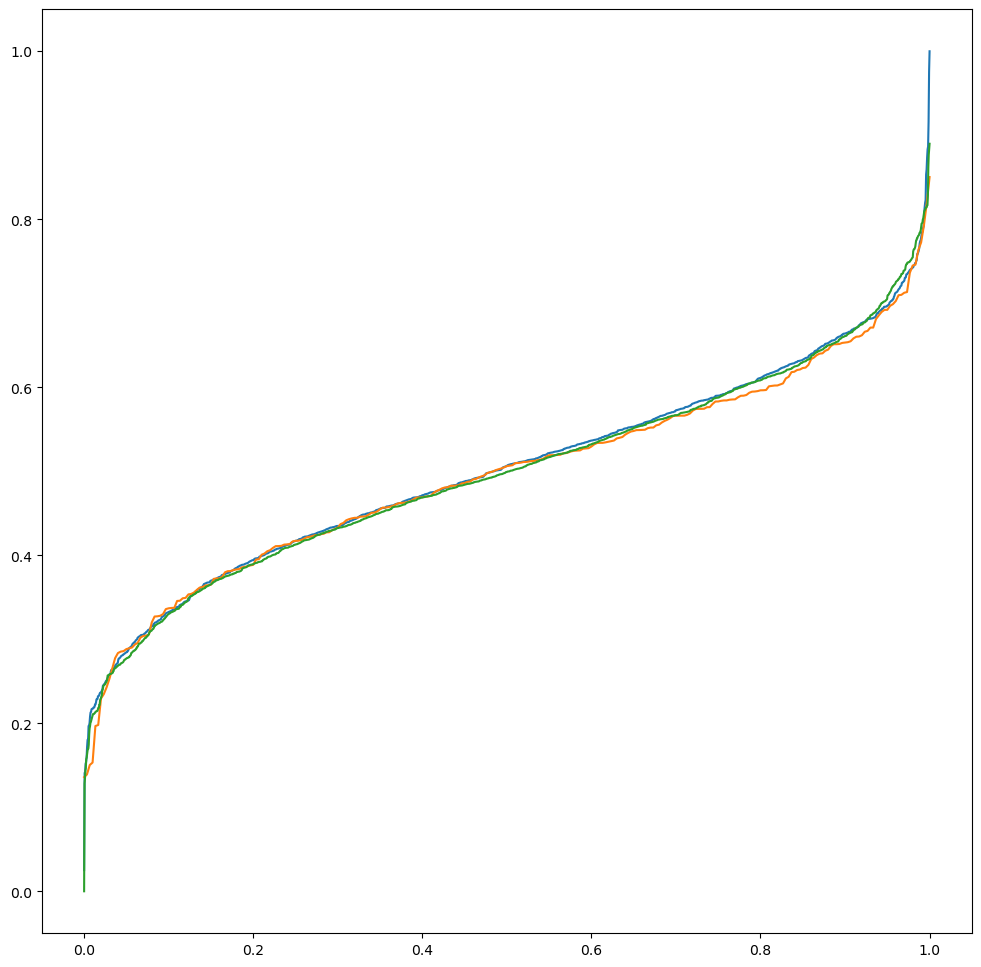

In [46]:
#Visualization of the distribution of values among the different sets: training, validation and test.
plt.figure()
plt.plot(np.linspace(0,1,len(ytrain)),sorted(ytrain))
plt.plot(np.linspace(0,1,len(yval)),sorted(yval))
plt.plot(np.linspace(0,1,len(ytest)),sorted(ytest))
plt.show()
plt.close()

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

stopping =  EarlyStopping(monitor='val_mae', patience=250, verbose=0, mode='auto', restore_best_weights=True)
model= tf.keras.Sequential([
    tf.keras.layers.InputLayer(Xtrain[0].shape[0]),
    #tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.Dense(units=256, activation='relu'),
    #tf.keras.layers.Dense(units=128, activation='relu'),
    #tf.keras.layers.Dense(units=128, activation='relu'), 
    #tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=32, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1, activation='linear')      
])

## Coulomb Matrix

In [48]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mean_absolute_error',
    metrics=['mae'])
    #metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [49]:
# Summarize model trainable parameters. 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               14080     
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                      

In [50]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 512
EPOCHS = 1000
dataset = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain))
dataset = dataset.repeat()  # Repeat the dataset indefinitely
dataset = dataset.batch(BATCH_SIZE)

In [51]:
history = model.fit(
    dataset,
    steps_per_epoch=100, #int(len(X_train) / int(BATCH_SIZE)),
    epochs=EPOCHS,
    #shuffle = True,
    validation_data=(Xval, yval),
    #validation_steps=500, #int(len(X_val / int(BATCH_SIZE)))
    verbose=1,
    callbacks=[stopping]
)

Epoch 1/1000
100/100 [==============================] - 2s 8ms/step - loss: 0.5516 - mae: 0.5516 - val_loss: 0.1538 - val_mae: 0.1538
Epoch 2/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.2044 - mae: 0.2044 - val_loss: 0.1102 - val_mae: 0.1102
Epoch 3/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.1324 - mae: 0.1324 - val_loss: 0.0936 - val_mae: 0.0936
Epoch 4/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.1065 - mae: 0.1065 - val_loss: 0.0859 - val_mae: 0.0859
Epoch 5/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0910 - mae: 0.0910 - val_loss: 0.0744 - val_mae: 0.0744
Epoch 6/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0822 - mae: 0.0822 - val_loss: 0.0666 - val_mae: 0.0666
Epoch 7/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0751 - mae: 0.0751 - val_loss: 0.0604 - val_mae: 0.0604
Epoch 8/1000
100/100 [==============================] - 1s 7ms

Epoch 62/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0446 - val_mae: 0.0446
Epoch 63/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0444 - val_mae: 0.0444
Epoch 64/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0448 - val_mae: 0.0448
Epoch 65/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0445 - val_mae: 0.0445
Epoch 66/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0439 - val_mae: 0.0439
Epoch 67/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0433 - val_mae: 0.0433
Epoch 68/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 69/1000
100/100 [==============================] 

100/100 [==============================] - 1s 7ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 123/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0438 - val_mae: 0.0438
Epoch 124/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0456 - val_mae: 0.0456
Epoch 125/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0450 - val_mae: 0.0450
Epoch 126/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0448 - val_mae: 0.0448
Epoch 127/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0436 - val_mae: 0.0436
Epoch 128/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0443 - val_mae: 0.0443
Epoch 129/1000
100/100 [==============================] - 1s 6m

100/100 [==============================] - 1s 7ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 183/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0444 - val_mae: 0.0444
Epoch 184/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0154 - mae: 0.0154 - val_loss: 0.0457 - val_mae: 0.0457
Epoch 185/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0439 - val_mae: 0.0439
Epoch 186/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0449 - val_mae: 0.0449
Epoch 187/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 188/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0458 - val_mae: 0.0458
Epoch 189/1000
100/100 [==============================] - 1s 6m

100/100 [==============================] - 1s 6ms/step - loss: 0.0139 - mae: 0.0139 - val_loss: 0.0458 - val_mae: 0.0458
Epoch 243/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0450 - val_mae: 0.0450
Epoch 244/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0452 - val_mae: 0.0452
Epoch 245/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 246/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0453 - val_mae: 0.0453
Epoch 247/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0139 - mae: 0.0139 - val_loss: 0.0453 - val_mae: 0.0453
Epoch 248/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0445 - val_mae: 0.0445
Epoch 249/1000
100/100 [==============================] - 1s 7m

100/100 [==============================] - 1s 7ms/step - loss: 0.0131 - mae: 0.0131 - val_loss: 0.0449 - val_mae: 0.0449
Epoch 303/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0444 - val_mae: 0.0444
Epoch 304/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0452 - val_mae: 0.0452
Epoch 305/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 306/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0455 - val_mae: 0.0455
Epoch 307/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0130 - mae: 0.0130 - val_loss: 0.0453 - val_mae: 0.0453
Epoch 308/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 309/1000
100/100 [==============================] - 1s 6m

In [52]:
model.save('./NN_models/cm_own_nn_model.h5')

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
0.04395851865410805
0.042245980352163315


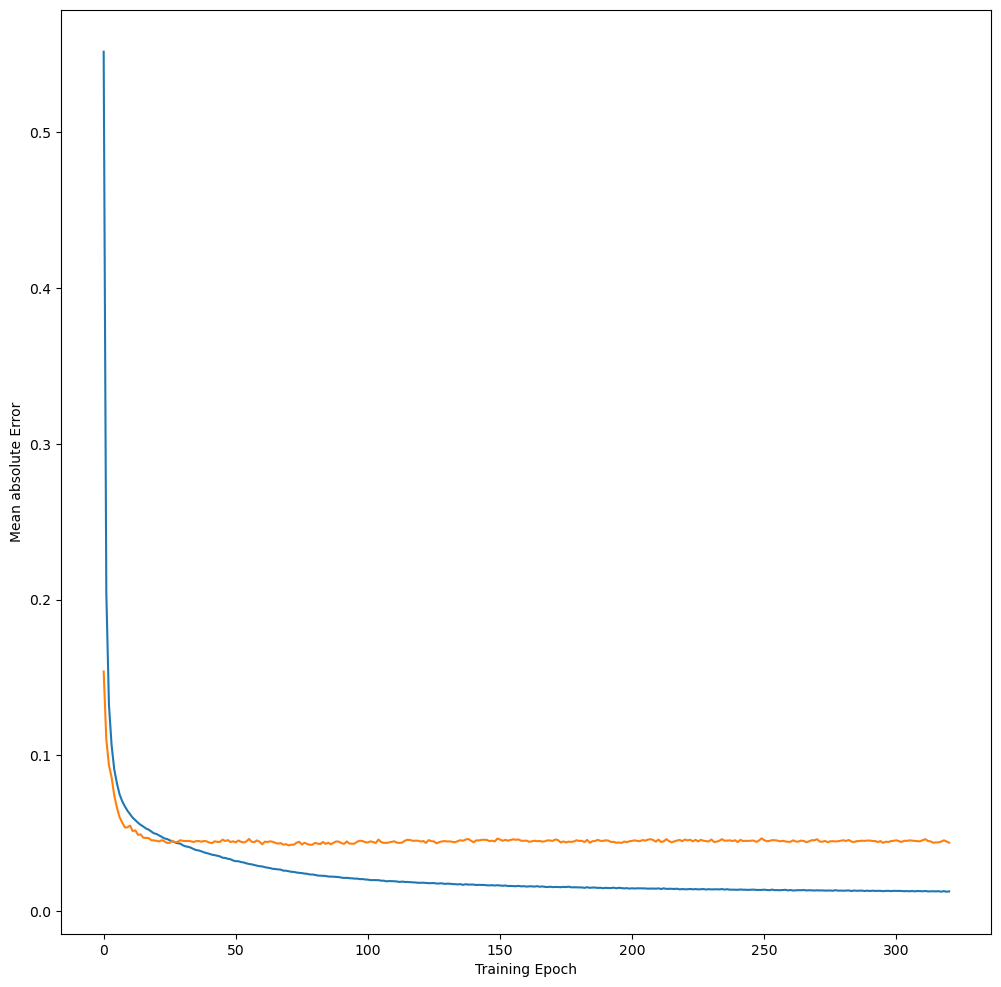

In [53]:
plt.figure()
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_mae'])
plt.ylabel('Mean absolute Error')
plt.xlabel('Training Epoch')
#plt.ylim(0,100)
print(history.history['val_loss'][-1])
print(min(history.history['val_mae']))
plt.show()
plt.close()

In [54]:
if adjustment == 'minimised':
    mined_ypred = model.predict(Xtest)
    ypred = []
    for i in range(len(mined_ypred)):
        oldE = mined_ypred[i]+min(energy)
        ypred.append(oldE)

    ypred = np.array(ypred)
    
    y_test = []
    for i in range(len(ytest)):
        oldE = ytest[i]+min(energy)
        y_test.append(oldE)

    y_test = np.array(y_test)
    
elif adjustment == 'normalised':
    norma_ypred = model.predict(Xtest)
    ypred = denorma(norma_ypred, energy)
    y_test = denorma(ytest, energy)
    
elif adjustment == 'minimised_normalised':
    list_ypred = model.predict(Xtest)
    ypred = []
    trash = denorma(list_ypred, energy)
    for i in range(len(trash)):
        oldE = trash[i]+min(energy)
        ypred.append(oldE)

    ypred = np.array(ypred)    
    
    y_test = []
    trash = denorma(ytest, energy)
    for i in range(len(trash)):
        oldE = trash[i]+min(energy)
        y_test.append(oldE)

    y_test = np.array(y_test)  

63/63 [==============================] - 0s 624us/step


In [55]:
y_test

array([-1008640.03400883, -1008638.64877784, -1008639.31060985, ...,
       -1008636.36582188, -1008635.2555666 , -1008637.25916078])

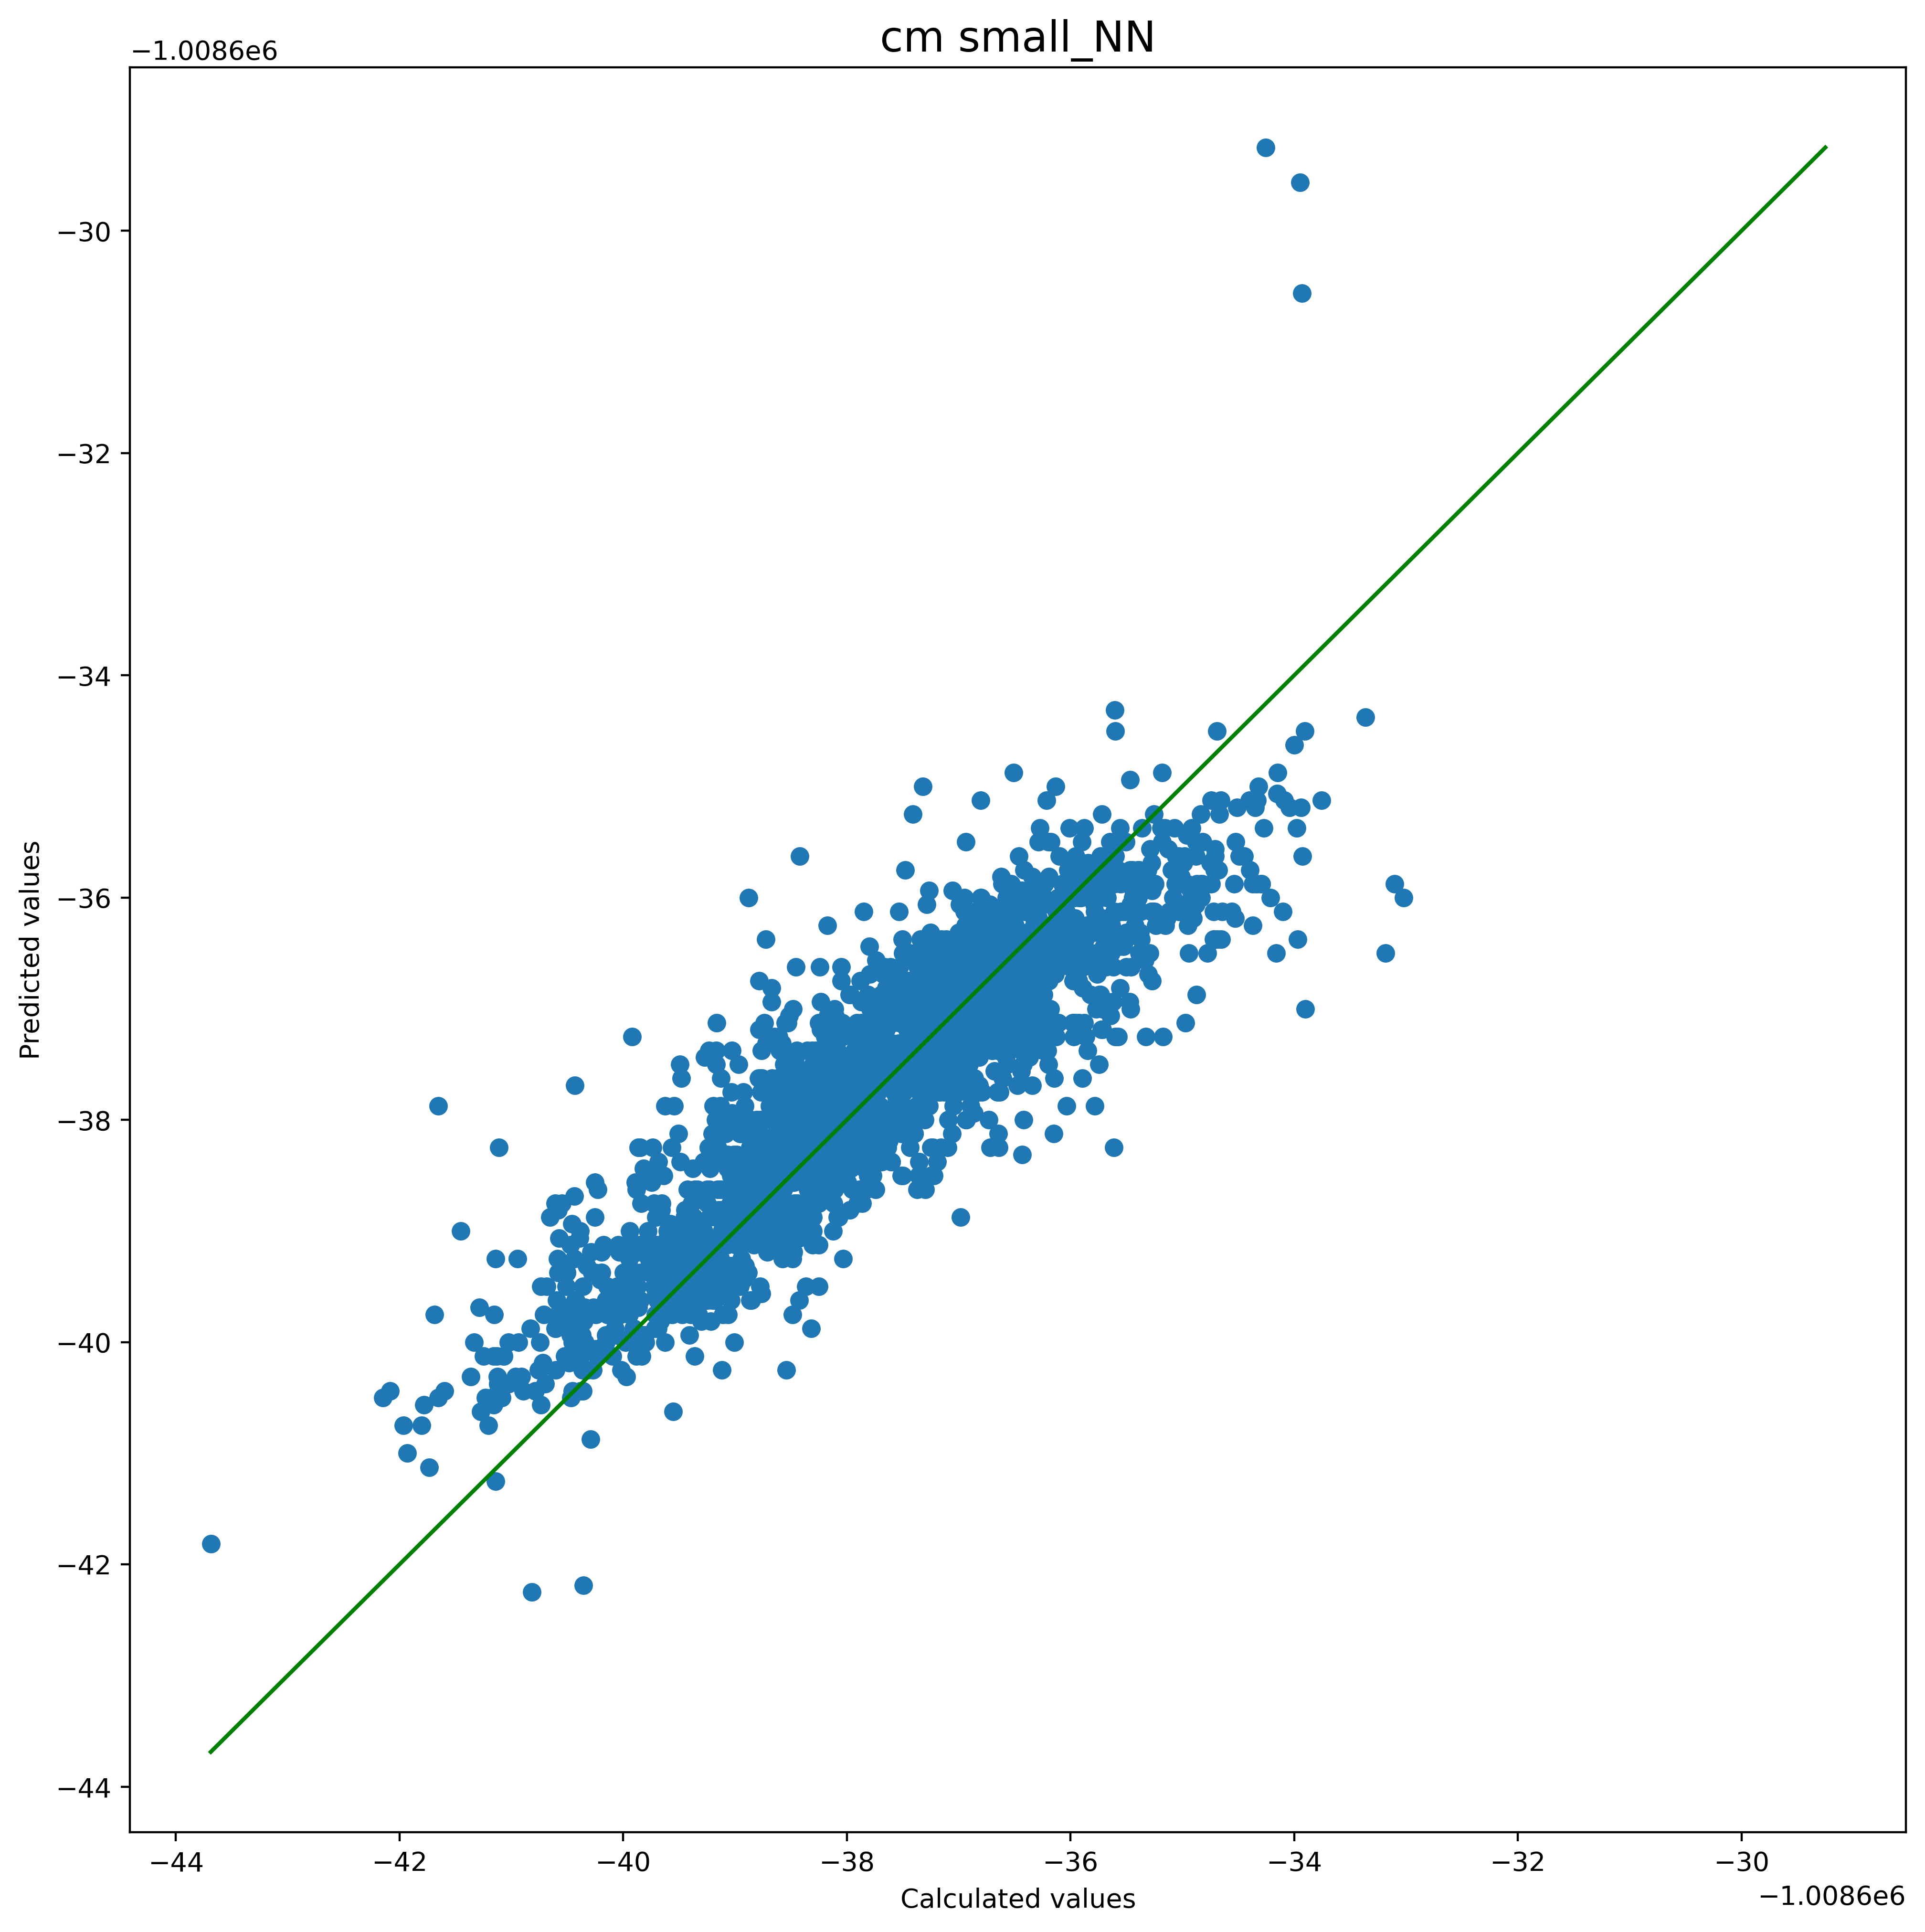

,r^2 value,mean absolute error,maximum error
0,0.767468,553.596747,5005.050103


In [56]:
errorgraph(y_test,ypred, descriptor_name, 'small_NN')

## Sine Matrix

In [26]:
print(descriptor_name)

sine


In [27]:
# preparing our data set
Xtrain, Xtest, ytrain, ytest = train_test_split(descriptor, thisE, random_state=1, test_size = tests)
print("Number of training examples before validation: {}".format(len(Xtrain)))
print("Number of test examples:     {}".format(len(Xtest)))
print("input shape:", Xtrain.shape)
print("output shape",ytrain.shape)

#reserving the 100 structures from the training set for validation
from numpy import random
Xval = Xtrain[-vals:]
yval = ytrain[-vals:]
Xtrain = Xtrain[:-vals]
ytrain = ytrain[:-vals]

print("Number of training examples after validation taken: {}".format(len(Xtrain)))
print("Number of validation examples: {}".format(len(Xval)))
print("Number of test examples:     {}".format(len(Xtest)))

#normalising the data that we are using:
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)
Xval = scaler.transform(Xval)

print('normalisation completed')

Number of training examples before validation: 2011
Number of test examples:     2012
input shape: (2011, 54)
output shape (2011,)
Number of training examples after validation taken: 1710
Number of validation examples: 301
Number of test examples:     2012
normalisation completed


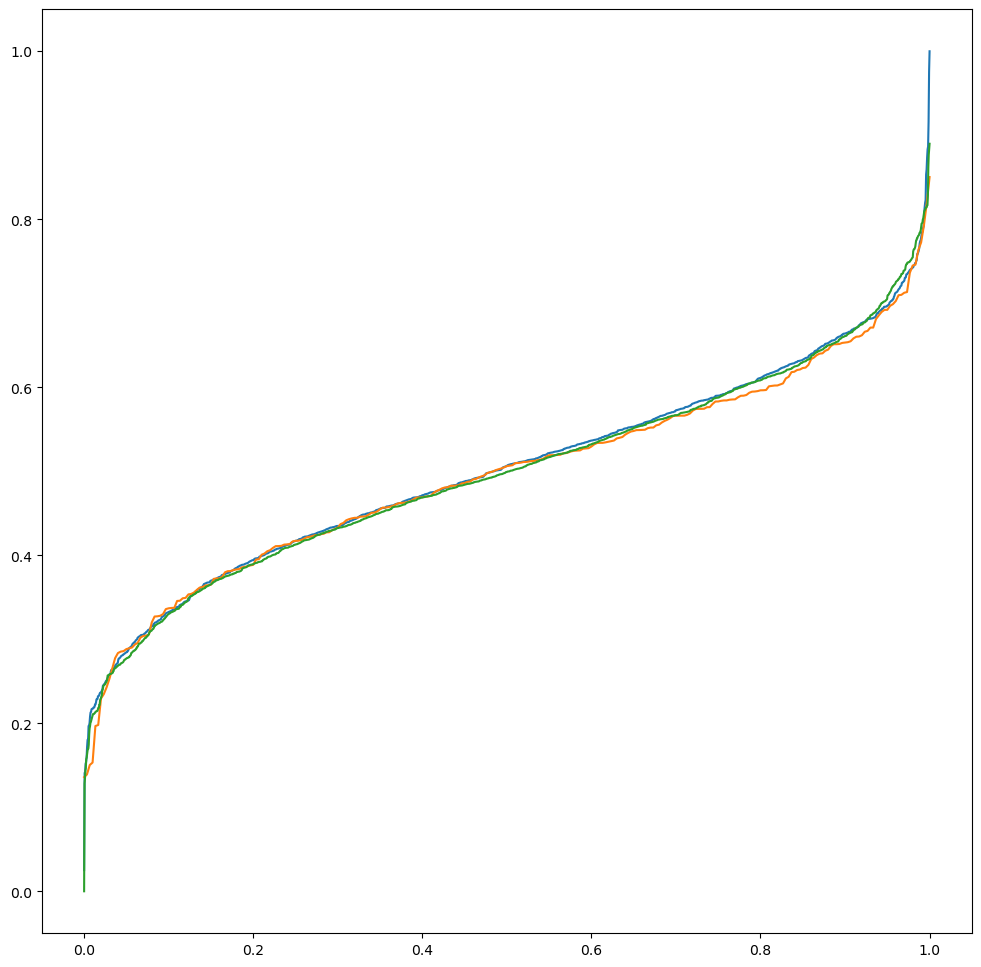

In [28]:
#Visualization of the distribution of values among the different sets: training, validation and test.
plt.figure()
plt.plot(np.linspace(0,1,len(ytrain)),sorted(ytrain))
plt.plot(np.linspace(0,1,len(yval)),sorted(yval))
plt.plot(np.linspace(0,1,len(ytest)),sorted(ytest))
plt.show()
plt.close()

In [40]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

stopping =  EarlyStopping(monitor='val_mae', patience=250, verbose=0, mode='auto', restore_best_weights=True)
model= tf.keras.Sequential([
    tf.keras.layers.InputLayer(Xtrain[0].shape[0]),
    #tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.Dense(units=256, activation='relu'),
    #tf.keras.layers.Dense(units=128, activation='relu'),
    #tf.keras.layers.Dense(units=128, activation='relu'), 
    #tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=32, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='linear')      
])

In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mean_absolute_error',
    metrics=['mae'])
    #metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [42]:
# Summarize model trainable parameters. 
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               14080     
                                                                 
 batch_normalization_15 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_16 (Bat  (None, 128)              512       
 chNormalization)                                     

In [43]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 512
EPOCHS = 1000
dataset = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain))
dataset = dataset.repeat()  # Repeat the dataset indefinitely
dataset = dataset.batch(BATCH_SIZE)

In [44]:
history = model.fit(
    dataset,
    steps_per_epoch=100, #int(len(X_train) / int(BATCH_SIZE)),
    epochs=EPOCHS,
    #shuffle = True,
    validation_data=(Xval, yval),
    #validation_steps=500, #int(len(X_val / int(BATCH_SIZE)))
    verbose=1,
    callbacks=[stopping]
)

Epoch 1/1000
100/100 [==============================] - 2s 8ms/step - loss: 0.6382 - mae: 0.6382 - val_loss: 0.1911 - val_mae: 0.1911
Epoch 2/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.3453 - mae: 0.3453 - val_loss: 0.1316 - val_mae: 0.1316
Epoch 3/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.2397 - mae: 0.2397 - val_loss: 0.1143 - val_mae: 0.1143
Epoch 4/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.1874 - mae: 0.1874 - val_loss: 0.0964 - val_mae: 0.0964
Epoch 5/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.1586 - mae: 0.1586 - val_loss: 0.0898 - val_mae: 0.0898
Epoch 6/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.1398 - mae: 0.1398 - val_loss: 0.0870 - val_mae: 0.0870
Epoch 7/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.1274 - mae: 0.1274 - val_loss: 0.0841 - val_mae: 0.0841
Epoch 8/1000
100/100 [==============================] - 1s 7ms

Epoch 62/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.0430 - mae: 0.0430 - val_loss: 0.0918 - val_mae: 0.0918
Epoch 63/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.0425 - mae: 0.0425 - val_loss: 0.0934 - val_mae: 0.0934
Epoch 64/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.0424 - mae: 0.0424 - val_loss: 0.0924 - val_mae: 0.0924
Epoch 65/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.0419 - mae: 0.0419 - val_loss: 0.0933 - val_mae: 0.0933
Epoch 66/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.0418 - mae: 0.0418 - val_loss: 0.0924 - val_mae: 0.0924
Epoch 67/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.0414 - mae: 0.0414 - val_loss: 0.0929 - val_mae: 0.0929
Epoch 68/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.0411 - mae: 0.0411 - val_loss: 0.0922 - val_mae: 0.0922
Epoch 69/1000
100/100 [==============================] 

100/100 [==============================] - 1s 7ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0933 - val_mae: 0.0933
Epoch 123/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0947 - val_mae: 0.0947
Epoch 124/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0939 - val_mae: 0.0939
Epoch 125/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0938 - val_mae: 0.0938
Epoch 126/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0932 - val_mae: 0.0932
Epoch 127/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0945 - val_mae: 0.0945
Epoch 128/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0938 - val_mae: 0.0938
Epoch 129/1000
100/100 [==============================] - 1s 7m

100/100 [==============================] - 1s 7ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0949 - val_mae: 0.0949
Epoch 183/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0945 - val_mae: 0.0945
Epoch 184/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0947 - val_mae: 0.0947
Epoch 185/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0939 - val_mae: 0.0939
Epoch 186/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0938 - val_mae: 0.0938
Epoch 187/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0919 - val_mae: 0.0919
Epoch 188/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0932 - val_mae: 0.0932
Epoch 189/1000
100/100 [==============================] - 1s 7m

100/100 [==============================] - 1s 7ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0935 - val_mae: 0.0935
Epoch 243/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0943 - val_mae: 0.0943
Epoch 244/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0937 - val_mae: 0.0937
Epoch 245/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0932 - val_mae: 0.0932
Epoch 246/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0934 - val_mae: 0.0934
Epoch 247/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0945 - val_mae: 0.0945
Epoch 248/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0941 - val_mae: 0.0941
Epoch 249/1000
100/100 [==============================] - 1s 7m

In [45]:
model.save('./NN_models/sine_nn_model.h5')

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
0.09394430369138718
0.07942642271518707


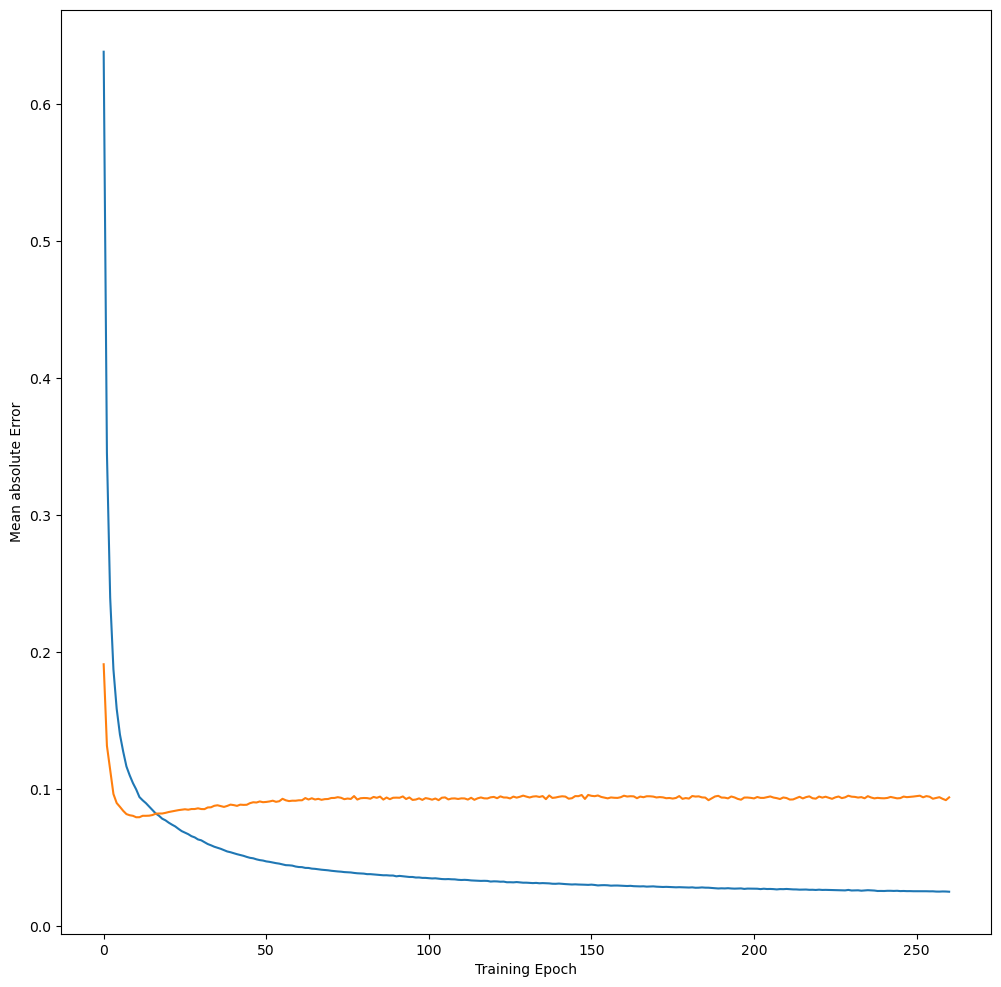

In [46]:
plt.figure()
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_mae'])
plt.ylabel('Mean absolute Error')
plt.xlabel('Training Epoch')
#plt.ylim(0,100)
print(history.history['val_loss'][-1])
print(min(history.history['val_mae']))
plt.show()
plt.close()

In [47]:
if adjustment == 'minimised':
    mined_ypred = model.predict(Xtest)
    ypred = []
    for i in range(len(mined_ypred)):
        oldE = mined_ypred[i]+min(energy)
        ypred.append(oldE)

    ypred = np.array(ypred)
    
    y_test = []
    for i in range(len(ytest)):
        oldE = ytest[i]+min(energy)
        y_test.append(oldE)

    y_test = np.array(y_test)
    
elif adjustment == 'normalised':
    norma_ypred = model.predict(Xtest)
    ypred = denorma(norma_ypred, energy)
    y_test = denorma(ytest, energy)
    
elif adjustment == 'minimised_normalised':
    list_ypred = model.predict(Xtest)
    ypred = []
    trash = denorma(list_ypred, energy)
    for i in range(len(trash)):
        oldE = trash[i]+min(energy)
        ypred.append(oldE)

    ypred = np.array(ypred)    
    
    y_test = []
    trash = denorma(ytest, energy)
    for i in range(len(trash)):
        oldE = trash[i]+min(energy)
        y_test.append(oldE)

    y_test = np.array(y_test)  

63/63 [==============================] - 0s 1ms/step


In [48]:
y_test

array([-1008640.03400883, -1008638.64877784, -1008639.31060985, ...,
       -1008636.36582188, -1008635.2555666 , -1008637.25916078])

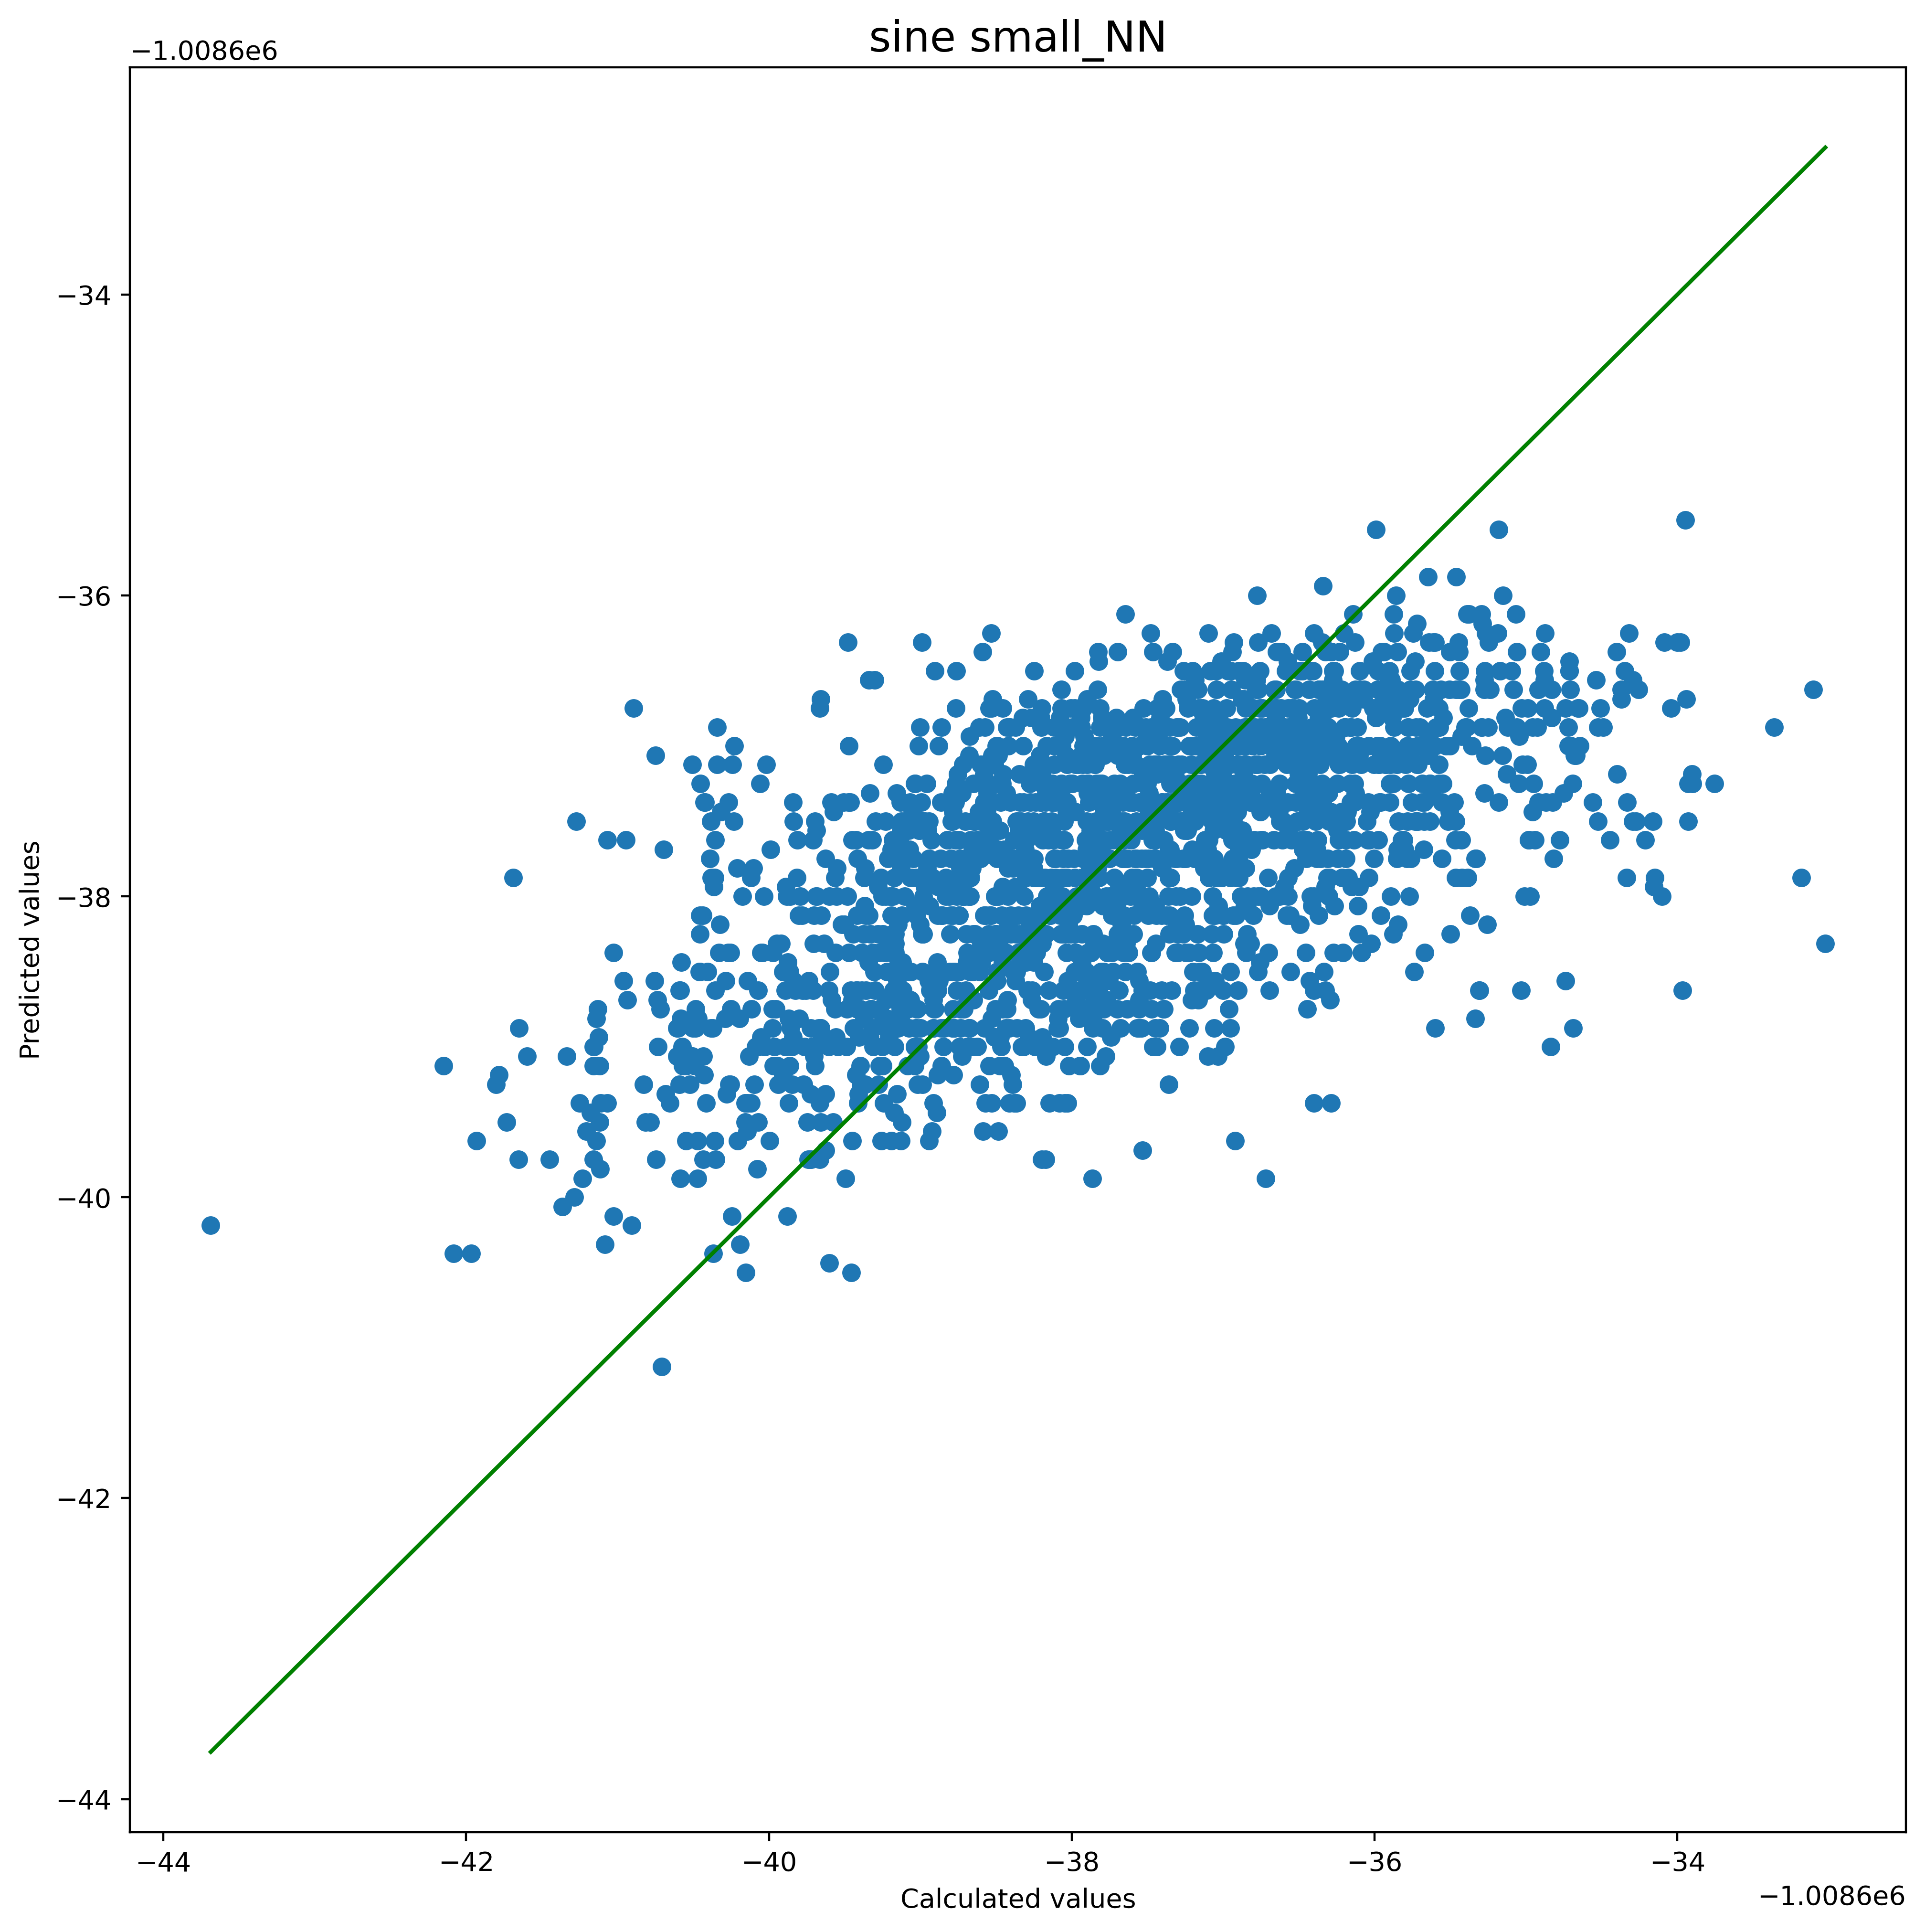

,r^2 value,mean absolute error,maximum error
0,0.363841,957.523132,5290.005202


In [49]:
errorgraph(y_test,ypred, descriptor_name, 'small_NN')

## Ewald Matrix

In [73]:
# preparing our data set
Xtrain, Xtest, ytrain, ytest = train_test_split(descriptor, thisE, random_state=1, test_size = tests)
print("Number of training examples before validation: {}".format(len(Xtrain)))
print("Number of test examples:     {}".format(len(Xtest)))
print("input shape:", Xtrain.shape)
print("output shape",ytrain.shape)

#reserving the 100 structures from the training set for validation
from numpy import random
Xval = Xtrain[-vals:]
yval = ytrain[-vals:]
Xtrain = Xtrain[:-vals]
ytrain = ytrain[:-vals]

print("Number of training examples after validation taken: {}".format(len(Xtrain)))
print("Number of validation examples: {}".format(len(Xval)))
print("Number of test examples:     {}".format(len(Xtest)))

#normalising the data that we are using:
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)
Xval = scaler.transform(Xval)

print('normalisation completed')

Number of training examples before validation: 2816
Number of test examples:     1207
input shape: (2816, 54)
output shape (2816,)
Number of training examples after validation taken: 2394
Number of validation examples: 422
Number of test examples:     1207
normalisation completed


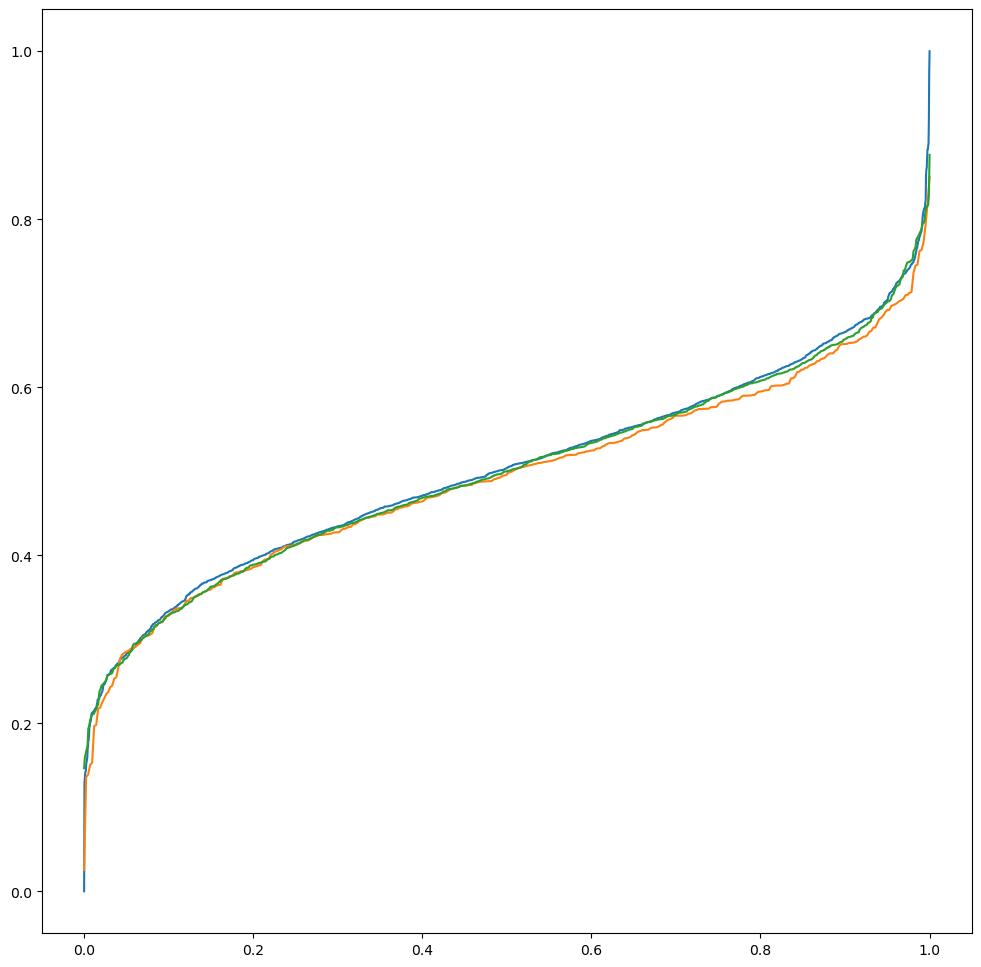

In [74]:
#Visualization of the distribution of values among the different sets: training, validation and test.
plt.figure()
plt.plot(np.linspace(0,1,len(ytrain)),sorted(ytrain))
plt.plot(np.linspace(0,1,len(yval)),sorted(yval))
plt.plot(np.linspace(0,1,len(ytest)),sorted(ytest))
plt.show()
plt.close()

In [75]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

stopping =  EarlyStopping(monitor='val_mae', patience=250, verbose=0, mode='auto', restore_best_weights=True)
model= tf.keras.Sequential([
    tf.keras.layers.InputLayer(Xtrain[0].shape[0]),
    #tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.Dense(units=256, activation='relu'),
    #tf.keras.layers.Dense(units=128, activation='relu'),
    #tf.keras.layers.Dense(units=128, activation='relu'), 
    #tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=32, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1, activation='linear')      
])

In [76]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mean_absolute_error',
    metrics=['mae'])
    #metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [77]:
# Summarize model trainable parameters. 
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 256)               14080     
                                                                 
 batch_normalization_25 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_26 (Bat  (None, 128)              512       
 chNormalization)                                     

In [78]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 512
EPOCHS = 1000
dataset = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain))
dataset = dataset.repeat()  # Repeat the dataset indefinitely
dataset = dataset.batch(BATCH_SIZE)

In [79]:
history = model.fit(
    dataset,
    steps_per_epoch=100, #int(len(X_train) / int(BATCH_SIZE)),
    epochs=EPOCHS,
    #shuffle = True,
    validation_data=(Xval, yval),
    #validation_steps=500, #int(len(X_val / int(BATCH_SIZE)))
    verbose=1,
    callbacks=[stopping]
)

Epoch 1/1000
100/100 [==============================] - 2s 8ms/step - loss: 0.5863 - mae: 0.5863 - val_loss: 0.1612 - val_mae: 0.1612
Epoch 2/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.2384 - mae: 0.2384 - val_loss: 0.1240 - val_mae: 0.1240
Epoch 3/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.1526 - mae: 0.1526 - val_loss: 0.0992 - val_mae: 0.0992
Epoch 4/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.1176 - mae: 0.1176 - val_loss: 0.0851 - val_mae: 0.0851
Epoch 5/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0988 - mae: 0.0988 - val_loss: 0.0730 - val_mae: 0.0730
Epoch 6/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0865 - mae: 0.0865 - val_loss: 0.0656 - val_mae: 0.0656
Epoch 7/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0769 - mae: 0.0769 - val_loss: 0.0565 - val_mae: 0.0565
Epoch 8/1000
100/100 [==============================] - 1s 7ms

Epoch 62/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0311 - val_mae: 0.0311
Epoch 63/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 64/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0321 - val_mae: 0.0321
Epoch 65/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 66/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0318 - val_mae: 0.0318
Epoch 67/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 68/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0322 - val_mae: 0.0322
Epoch 69/1000
100/100 [==============================] 

100/100 [==============================] - 1s 7ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0311 - val_mae: 0.0311
Epoch 123/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0318 - val_mae: 0.0318
Epoch 124/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0320 - val_mae: 0.0320
Epoch 125/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0312 - val_mae: 0.0312
Epoch 126/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0308 - val_mae: 0.0308
Epoch 127/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 128/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0309 - val_mae: 0.0309
Epoch 129/1000
100/100 [==============================] - 1s 7m

100/100 [==============================] - 1s 7ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 183/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0312 - val_mae: 0.0312
Epoch 184/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0318 - val_mae: 0.0318
Epoch 185/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0310 - val_mae: 0.0310
Epoch 186/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 187/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0320 - val_mae: 0.0320
Epoch 188/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 189/1000
100/100 [==============================] - 1s 7m

100/100 [==============================] - 1s 7ms/step - loss: 0.0116 - mae: 0.0116 - val_loss: 0.0318 - val_mae: 0.0318
Epoch 243/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0114 - mae: 0.0114 - val_loss: 0.0315 - val_mae: 0.0315
Epoch 244/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0118 - mae: 0.0118 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 245/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0116 - mae: 0.0116 - val_loss: 0.0315 - val_mae: 0.0315
Epoch 246/1000
100/100 [==============================] - 1s 6ms/step - loss: 0.0117 - mae: 0.0117 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 247/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0113 - mae: 0.0113 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 248/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0115 - mae: 0.0115 - val_loss: 0.0322 - val_mae: 0.0322
Epoch 249/1000
100/100 [==============================] - 1s 6m

100/100 [==============================] - 1s 7ms/step - loss: 0.0109 - mae: 0.0109 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 303/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 304/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.0110 - mae: 0.0110 - val_loss: 0.0320 - val_mae: 0.0320
Epoch 305/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 306/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.0110 - mae: 0.0110 - val_loss: 0.0320 - val_mae: 0.0320
Epoch 307/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.0109 - mae: 0.0109 - val_loss: 0.0311 - val_mae: 0.0311
Epoch 308/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 309/1000
100/100 [==============================] - 1s 9m

100/100 [==============================] - 1s 7ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0317 - val_mae: 0.0317
Epoch 363/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0102 - mae: 0.0102 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 364/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 365/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0103 - mae: 0.0103 - val_loss: 0.0318 - val_mae: 0.0318
Epoch 366/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0103 - mae: 0.0103 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 367/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0322 - val_mae: 0.0322
Epoch 368/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0102 - mae: 0.0102 - val_loss: 0.0325 - val_mae: 0.0325
Epoch 369/1000
100/100 [==============================] - 1s 7m

In [80]:
model.save('./NN_models/ewald_nn_model.h5')

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
0.03218568116426468
0.030317610129714012


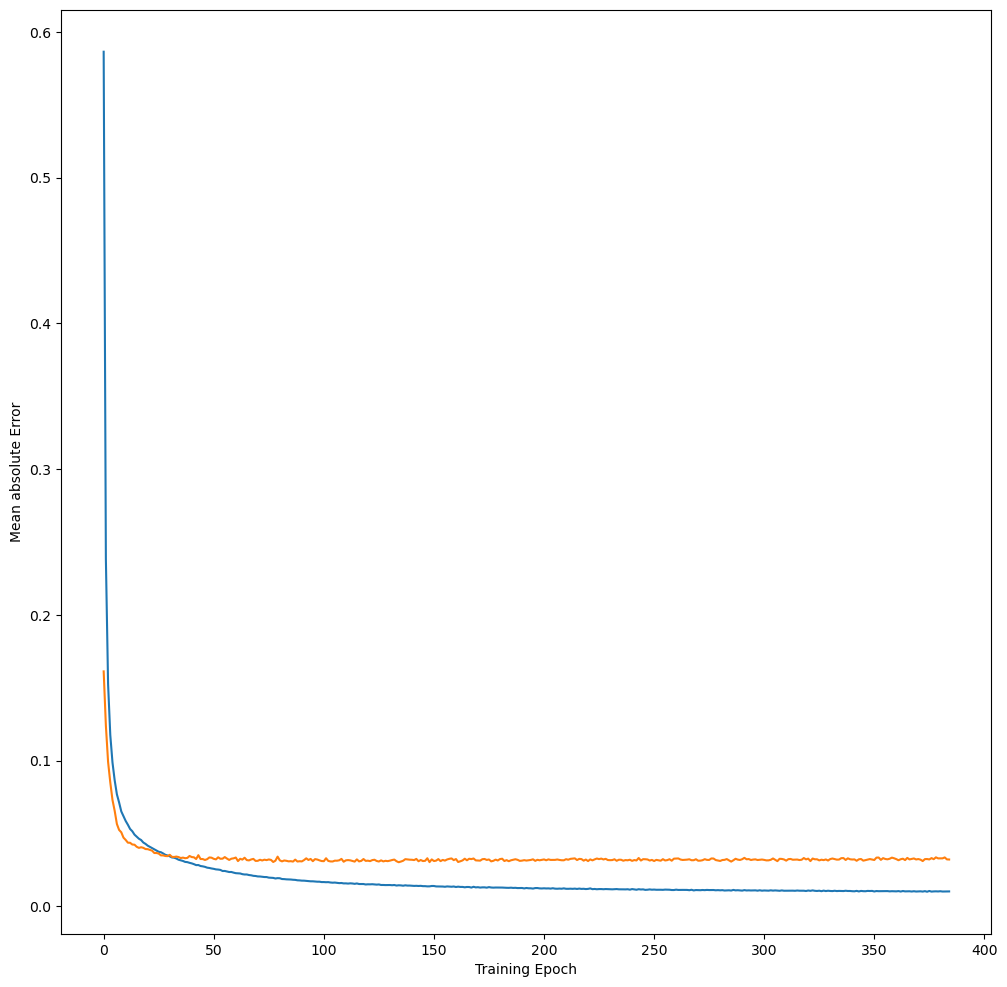

In [81]:
plt.figure()
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_mae'])
plt.ylabel('Mean absolute Error')
plt.xlabel('Training Epoch')
#plt.ylim(0,100)
print(history.history['val_loss'][-1])
print(min(history.history['val_mae']))
plt.show()
plt.close()

In [82]:
if adjustment == 'minimised':
    mined_ypred = model.predict(Xtest)
    ypred = []
    for i in range(len(mined_ypred)):
        oldE = mined_ypred[i]+min(energy)
        ypred.append(oldE)

    ypred = np.array(ypred)
    
    y_test = []
    for i in range(len(ytest)):
        oldE = ytest[i]+min(energy)
        y_test.append(oldE)

    y_test = np.array(y_test)
    
elif adjustment == 'normalised':
    norma_ypred = model.predict(Xtest)
    ypred = denorma(norma_ypred, energy)
    y_test = denorma(ytest, energy)
    
elif adjustment == 'minimised_normalised':
    list_ypred = model.predict(Xtest)
    ypred = []
    trash = denorma(list_ypred, energy)
    for i in range(len(trash)):
        oldE = trash[i]+min(energy)
        ypred.append(oldE)

    ypred = np.array(ypred)    
    
    y_test = []
    trash = denorma(ytest, energy)
    for i in range(len(trash)):
        oldE = trash[i]+min(energy)
        y_test.append(oldE)

    y_test = np.array(y_test)  

38/38 [==============================] - 0s 683us/step


In [83]:
y_test

array([-1008640.03400883, -1008638.64877784, -1008639.31060985, ...,
       -1008637.19855579, -1008636.64647622, -1008635.46818227])

In [84]:
ypred

array([[-1008639.3 ],
       [-1008638.25],
       [-1008639.6 ],
       ...,
       [-1008637.2 ],
       [-1008635.75],
       [-1008635.75]], dtype=float32)

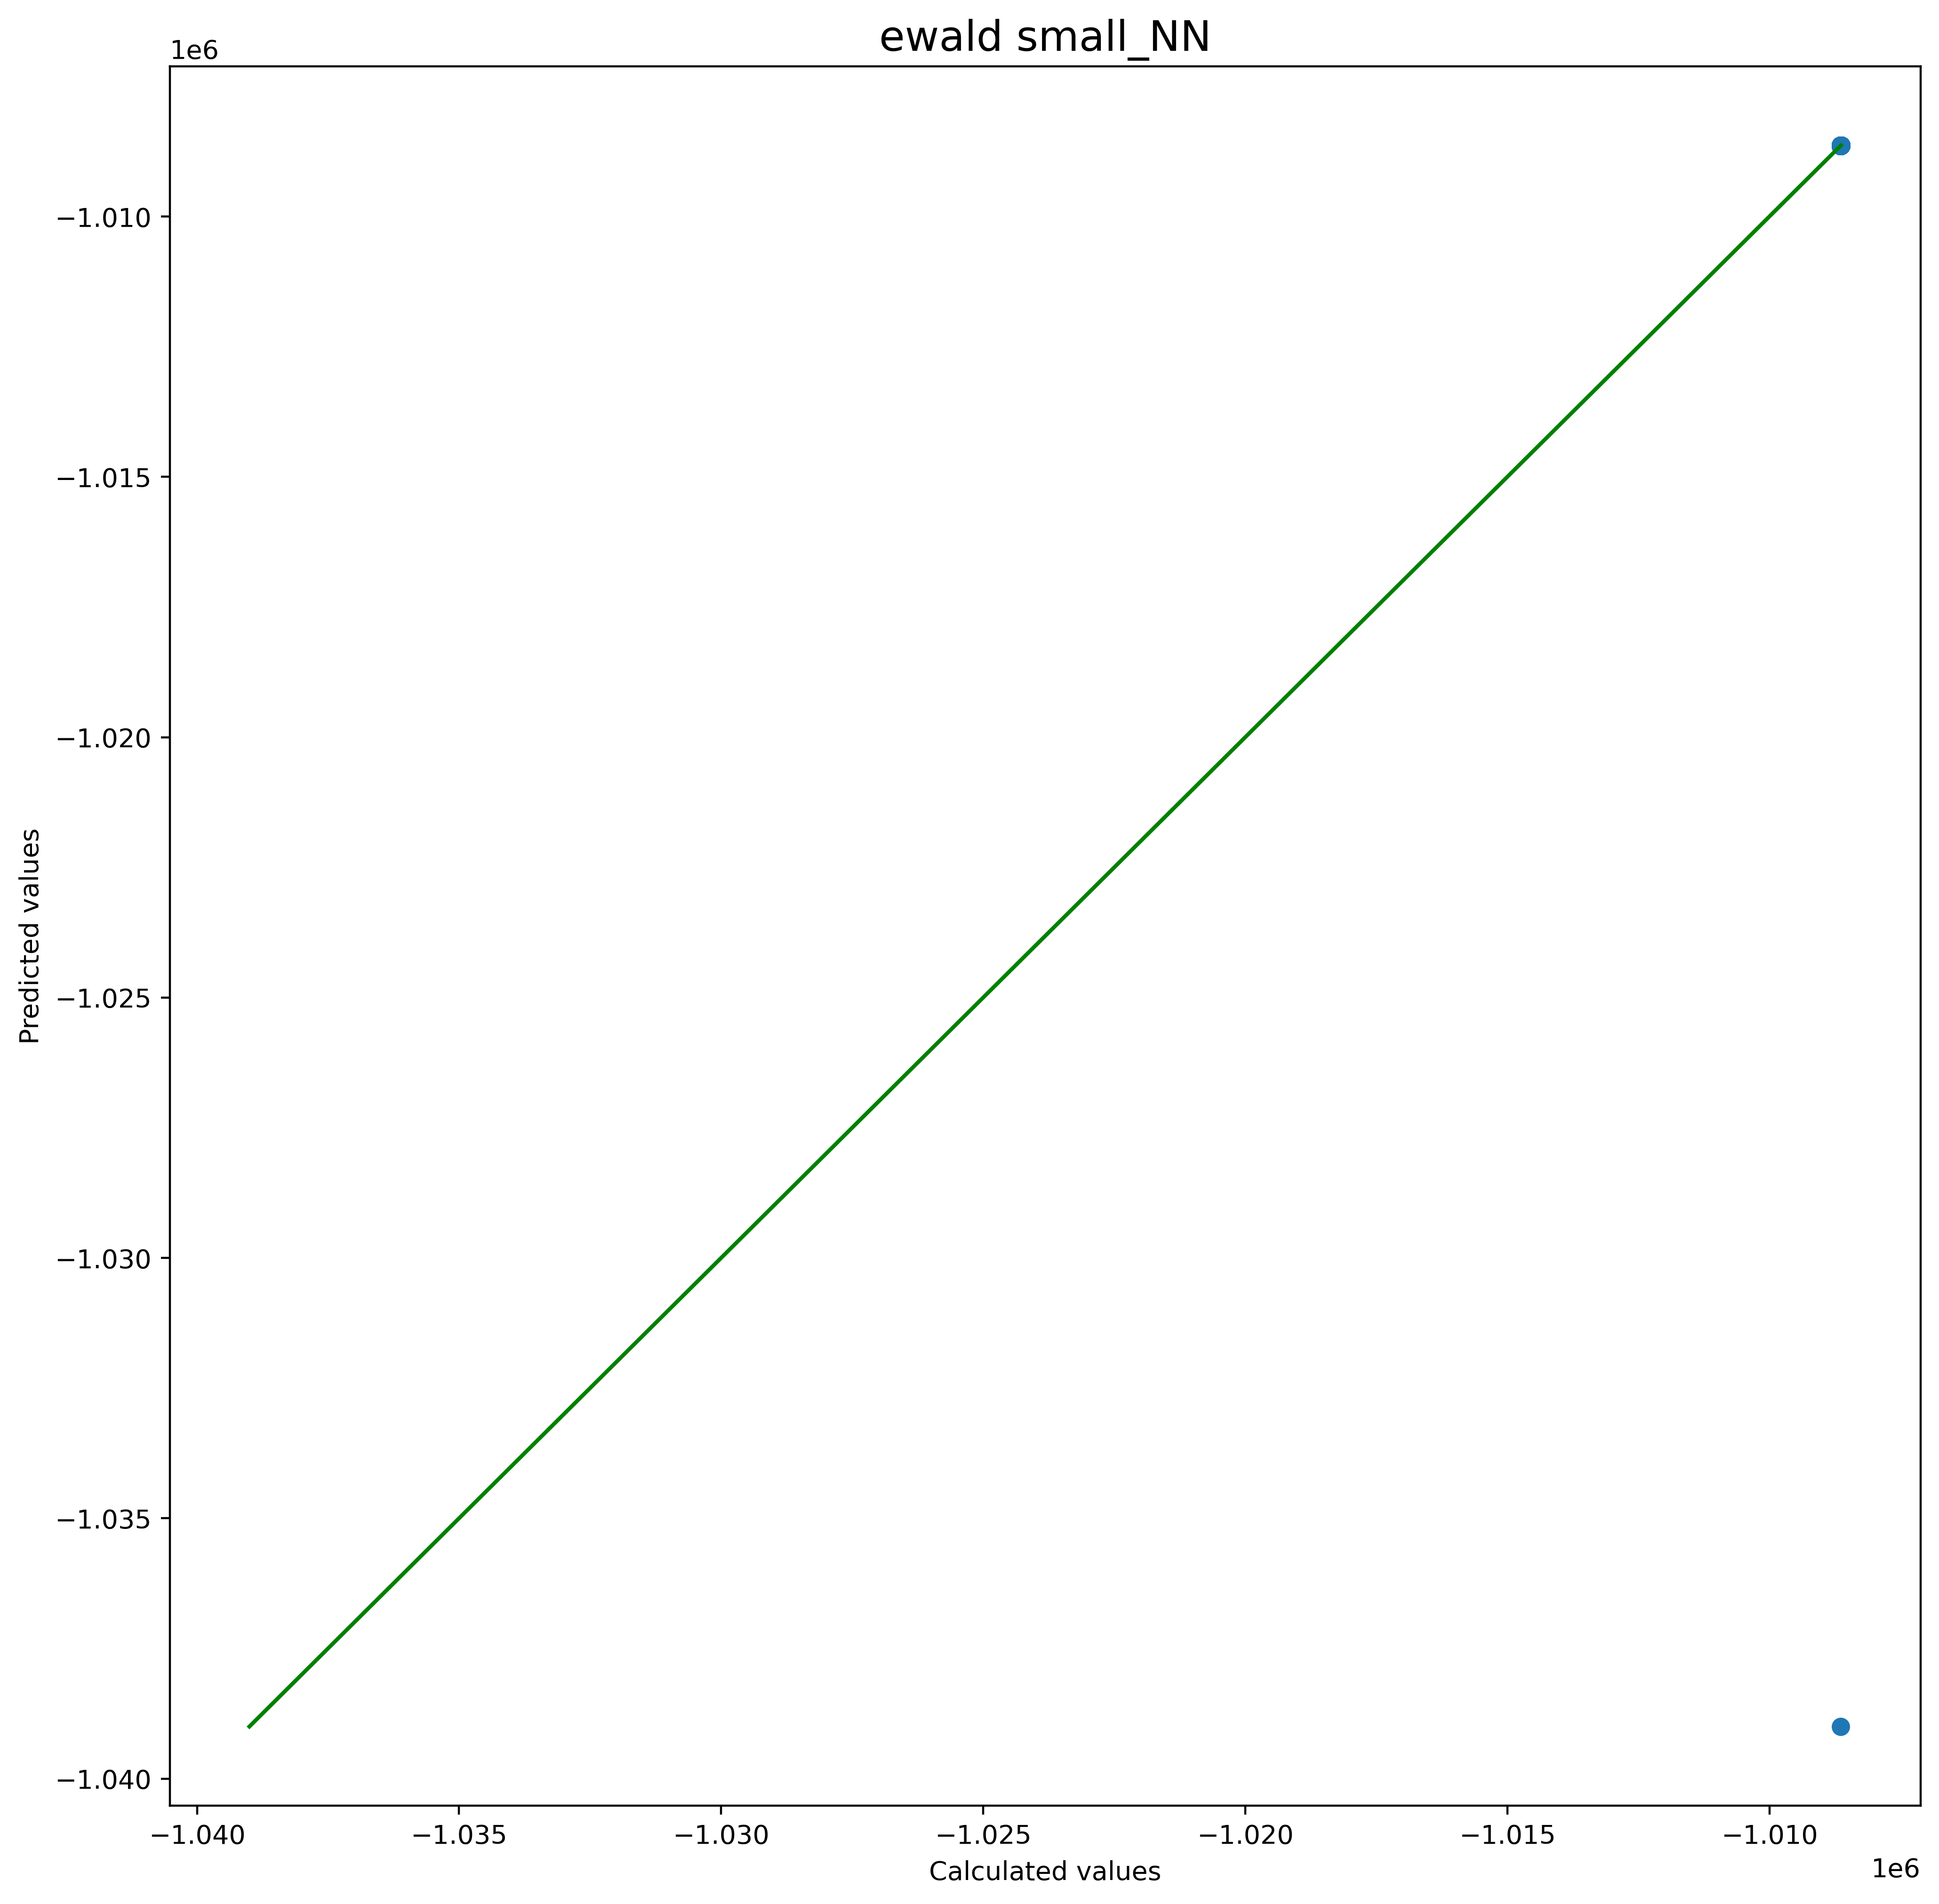

,r^2 value,mean absolute error,maximum error
0,-328215.743336,25516.303594,3.036278e+07


In [85]:
errorgraph(y_test,ypred, descriptor_name, 'small_NN')

### MBTR

In [105]:
# preparing our data set
Xtrain, Xtest, ytrain, ytest = train_test_split(descriptor, thisE, random_state=1, test_size = tests)
print("Number of training examples before validation: {}".format(len(Xtrain)))
print("Number of test examples:     {}".format(len(Xtest)))
print("input shape:", Xtrain.shape)
print("output shape",ytrain.shape)

#reserving the 100 structures from the training set for validation
from numpy import random
Xval = Xtrain[-vals:]
yval = ytrain[-vals:]
Xtrain = Xtrain[:-vals]
ytrain = ytrain[:-vals]

print("Number of training examples after validation taken: {}".format(len(Xtrain)))
print("Number of validation examples: {}".format(len(Xval)))
print("Number of test examples:     {}".format(len(Xtest)))

#normalising the data that we are using:
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)
Xval = scaler.transform(Xval)

print('normalisation completed')

Number of training examples before validation: 2816
Number of test examples:     1207
input shape: (2816, 3000)
output shape (2816,)
Number of training examples after validation taken: 2394
Number of validation examples: 422
Number of test examples:     1207
normalisation completed


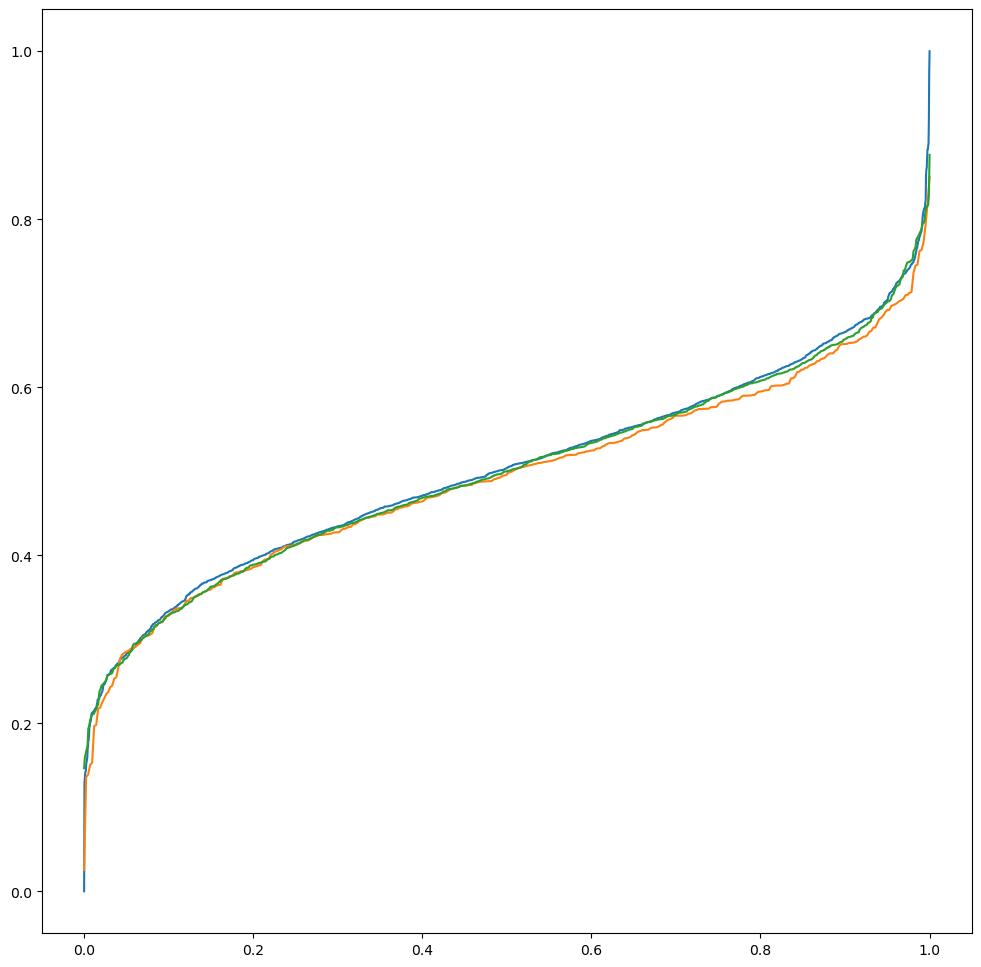

In [106]:
#Visualization of the distribution of values among the different sets: training, validation and test.
plt.figure()
plt.plot(np.linspace(0,1,len(ytrain)),sorted(ytrain))
plt.plot(np.linspace(0,1,len(yval)),sorted(yval))
plt.plot(np.linspace(0,1,len(ytest)),sorted(ytest))
plt.show()
plt.close()

In [107]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

stopping =  EarlyStopping(monitor='val_mae', patience=250, verbose=0, mode='auto', restore_best_weights=True)
model= tf.keras.Sequential([
    tf.keras.layers.InputLayer(Xtrain[0].shape[0]),
    #tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.Dense(units=256, activation='relu'),
    #tf.keras.layers.Dense(units=128, activation='relu'),
    #tf.keras.layers.Dense(units=128, activation='relu'), 
    #tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=32, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1, activation='linear')      
])

In [108]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mean_absolute_error',
    metrics=['mae'])
    #metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [109]:
# Summarize model trainable parameters. 
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 256)               768256    
                                                                 
 batch_normalization_35 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_36 (Bat  (None, 128)              512       
 chNormalization)                                     

In [110]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 512
EPOCHS = 1000
dataset = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain))
dataset = dataset.repeat()  # Repeat the dataset indefinitely
dataset = dataset.batch(BATCH_SIZE)

In [111]:
history = model.fit(
    dataset,
    steps_per_epoch=100, #int(len(X_train) / int(BATCH_SIZE)),
    epochs=EPOCHS,
    #shuffle = True,
    validation_data=(Xval, yval),
    #validation_steps=500, #int(len(X_val / int(BATCH_SIZE)))
    verbose=1,
    callbacks=[stopping]
)

Epoch 1/1000
100/100 [==============================] - 3s 22ms/step - loss: 0.5128 - mae: 0.5128 - val_loss: 0.1858 - val_mae: 0.1858
Epoch 2/1000
100/100 [==============================] - 2s 20ms/step - loss: 0.1723 - mae: 0.1723 - val_loss: 0.0588 - val_mae: 0.0588
Epoch 3/1000
100/100 [==============================] - 2s 20ms/step - loss: 0.1039 - mae: 0.1039 - val_loss: 0.0501 - val_mae: 0.0501
Epoch 4/1000
100/100 [==============================] - 2s 20ms/step - loss: 0.0771 - mae: 0.0771 - val_loss: 0.0353 - val_mae: 0.0353
Epoch 5/1000
100/100 [==============================] - 2s 20ms/step - loss: 0.0609 - mae: 0.0609 - val_loss: 0.0299 - val_mae: 0.0299
Epoch 6/1000
100/100 [==============================] - 2s 20ms/step - loss: 0.0515 - mae: 0.0515 - val_loss: 0.0268 - val_mae: 0.0268
Epoch 7/1000
100/100 [==============================] - 2s 20ms/step - loss: 0.0458 - mae: 0.0458 - val_loss: 0.0236 - val_mae: 0.0236
Epoch 8/1000
100/100 [==============================] -

100/100 [==============================] - 2s 21ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0144 - val_mae: 0.0144
Epoch 62/1000
100/100 [==============================] - 2s 24ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0145 - val_mae: 0.0145
Epoch 63/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0134 - val_mae: 0.0134
Epoch 64/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 65/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0150 - val_mae: 0.0150
Epoch 66/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0146 - val_mae: 0.0146
Epoch 67/1000
100/100 [==============================] - 2s 23ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0146 - val_mae: 0.0146
Epoch 68/1000
100/100 [==============================] - 2s 21

100/100 [==============================] - 2s 21ms/step - loss: 0.0158 - mae: 0.0158 - val_loss: 0.0139 - val_mae: 0.0139
Epoch 122/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0156 - mae: 0.0156 - val_loss: 0.0168 - val_mae: 0.0168
Epoch 123/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0159 - mae: 0.0159 - val_loss: 0.0143 - val_mae: 0.0143
Epoch 124/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0156 - mae: 0.0156 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 125/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0156 - mae: 0.0156 - val_loss: 0.0146 - val_mae: 0.0146
Epoch 126/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0157 - mae: 0.0157 - val_loss: 0.0133 - val_mae: 0.0133
Epoch 127/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0156 - mae: 0.0156 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 128/1000
100/100 [==============================] 

Epoch 181/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0136 - val_mae: 0.0136
Epoch 182/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0145 - val_mae: 0.0145
Epoch 183/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 184/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 185/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 186/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 187/1000
100/100 [==============================] - 2s 21ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0134 - val_mae: 0.0134
Epoch 188/1000
100/100 [=================

Epoch 241/1000
100/100 [==============================] - 2s 23ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0139 - val_mae: 0.0139
Epoch 242/1000
100/100 [==============================] - 2s 23ms/step - loss: 0.0141 - mae: 0.0141 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 243/1000
100/100 [==============================] - 3s 25ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0139 - val_mae: 0.0139
Epoch 244/1000
100/100 [==============================] - 2s 23ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0140 - val_mae: 0.0140
Epoch 245/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0141 - mae: 0.0141 - val_loss: 0.0135 - val_mae: 0.0135
Epoch 246/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0142 - val_mae: 0.0142
Epoch 247/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0152 - val_mae: 0.0152
Epoch 248/1000
100/100 [=================

Epoch 301/1000
100/100 [==============================] - 2s 23ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0152 - val_mae: 0.0152
Epoch 302/1000
100/100 [==============================] - 2s 24ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0143 - val_mae: 0.0143
Epoch 303/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0144 - val_mae: 0.0144
Epoch 304/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 305/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 306/1000
100/100 [==============================] - 2s 24ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0141 - val_mae: 0.0141
Epoch 307/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0165 - val_mae: 0.0165
Epoch 308/1000
100/100 [=================

Epoch 361/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 362/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 363/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 364/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0146 - val_mae: 0.0146
Epoch 365/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0169 - val_mae: 0.0169
Epoch 366/1000
100/100 [==============================] - 2s 23ms/step - loss: 0.0134 - mae: 0.0134 - val_loss: 0.0146 - val_mae: 0.0146
Epoch 367/1000
100/100 [==============================] - 2s 22ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 368/1000
100/100 [=================

In [112]:
model.save('./NN_models/mbtr_nn_model.h5')

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
0.014242416247725487
0.012777543626725674


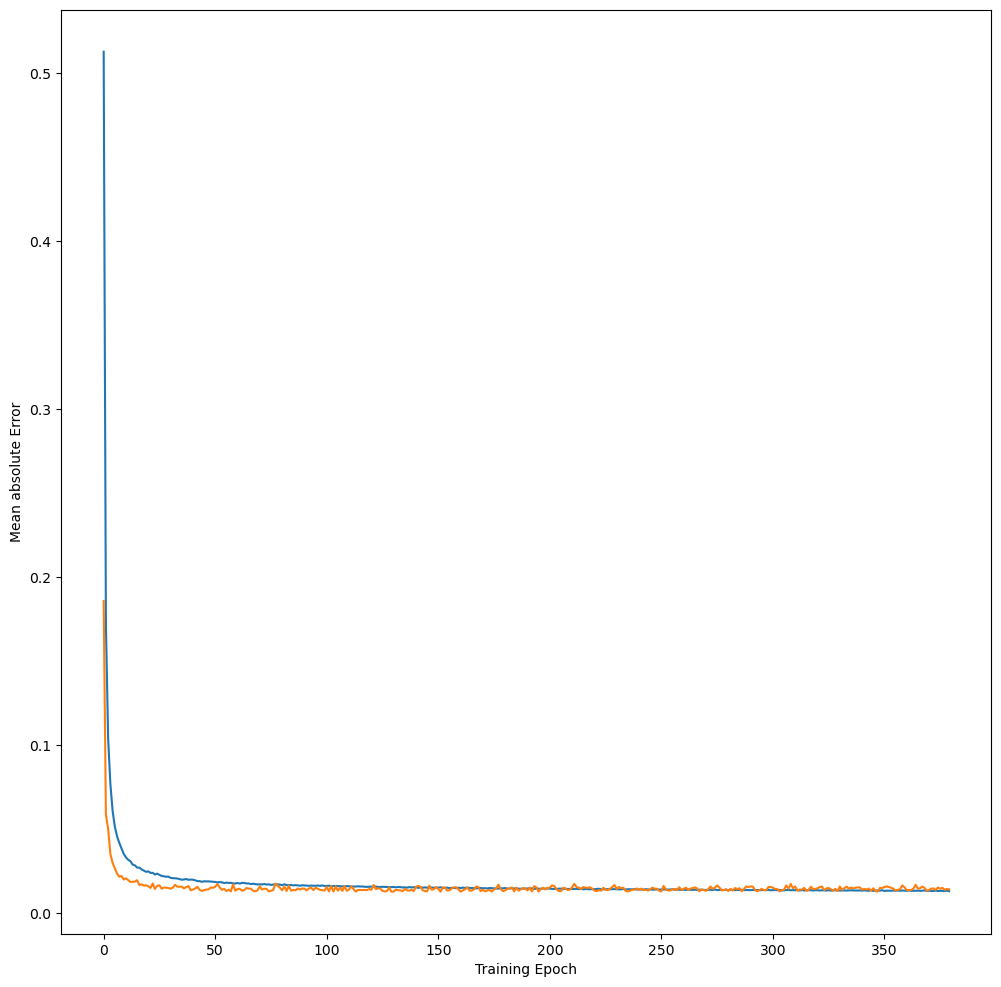

In [113]:
plt.figure()
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_mae'])
plt.ylabel('Mean absolute Error')
plt.xlabel('Training Epoch')
#plt.ylim(0,100)
print(history.history['val_loss'][-1])
print(min(history.history['val_mae']))
plt.show()
plt.close()

In [114]:
if adjustment == 'minimised':
    mined_ypred = model.predict(Xtest)
    ypred = []
    for i in range(len(mined_ypred)):
        oldE = mined_ypred[i]+min(energy)
        ypred.append(oldE)

    ypred = np.array(ypred)
    
    y_test = []
    for i in range(len(ytest)):
        oldE = ytest[i]+min(energy)
        y_test.append(oldE)

    y_test = np.array(y_test)
    
elif adjustment == 'normalised':
    norma_ypred = model.predict(Xtest)
    ypred = denorma(norma_ypred, energy)
    y_test = denorma(ytest, energy)
    
elif adjustment == 'minimised_normalised':
    list_ypred = model.predict(Xtest)
    ypred = []
    trash = denorma(list_ypred, energy)
    for i in range(len(trash)):
        oldE = trash[i]+min(energy)
        ypred.append(oldE)

    ypred = np.array(ypred)    
    
    y_test = []
    trash = denorma(ytest, energy)
    for i in range(len(trash)):
        oldE = trash[i]+min(energy)
        y_test.append(oldE)

    y_test = np.array(y_test)  

38/38 [==============================] - 0s 2ms/step


In [115]:
y_test

array([-1008640.03400883, -1008638.64877784, -1008639.31060985, ...,
       -1008637.19855579, -1008636.64647622, -1008635.46818227])

In [116]:
ypred

array([[-1008639.9 ],
       [-1008638.94],
       [-1008639.5 ],
       ...,
       [-1008637.  ],
       [-1008636.4 ],
       [-1008635.7 ]], dtype=float32)

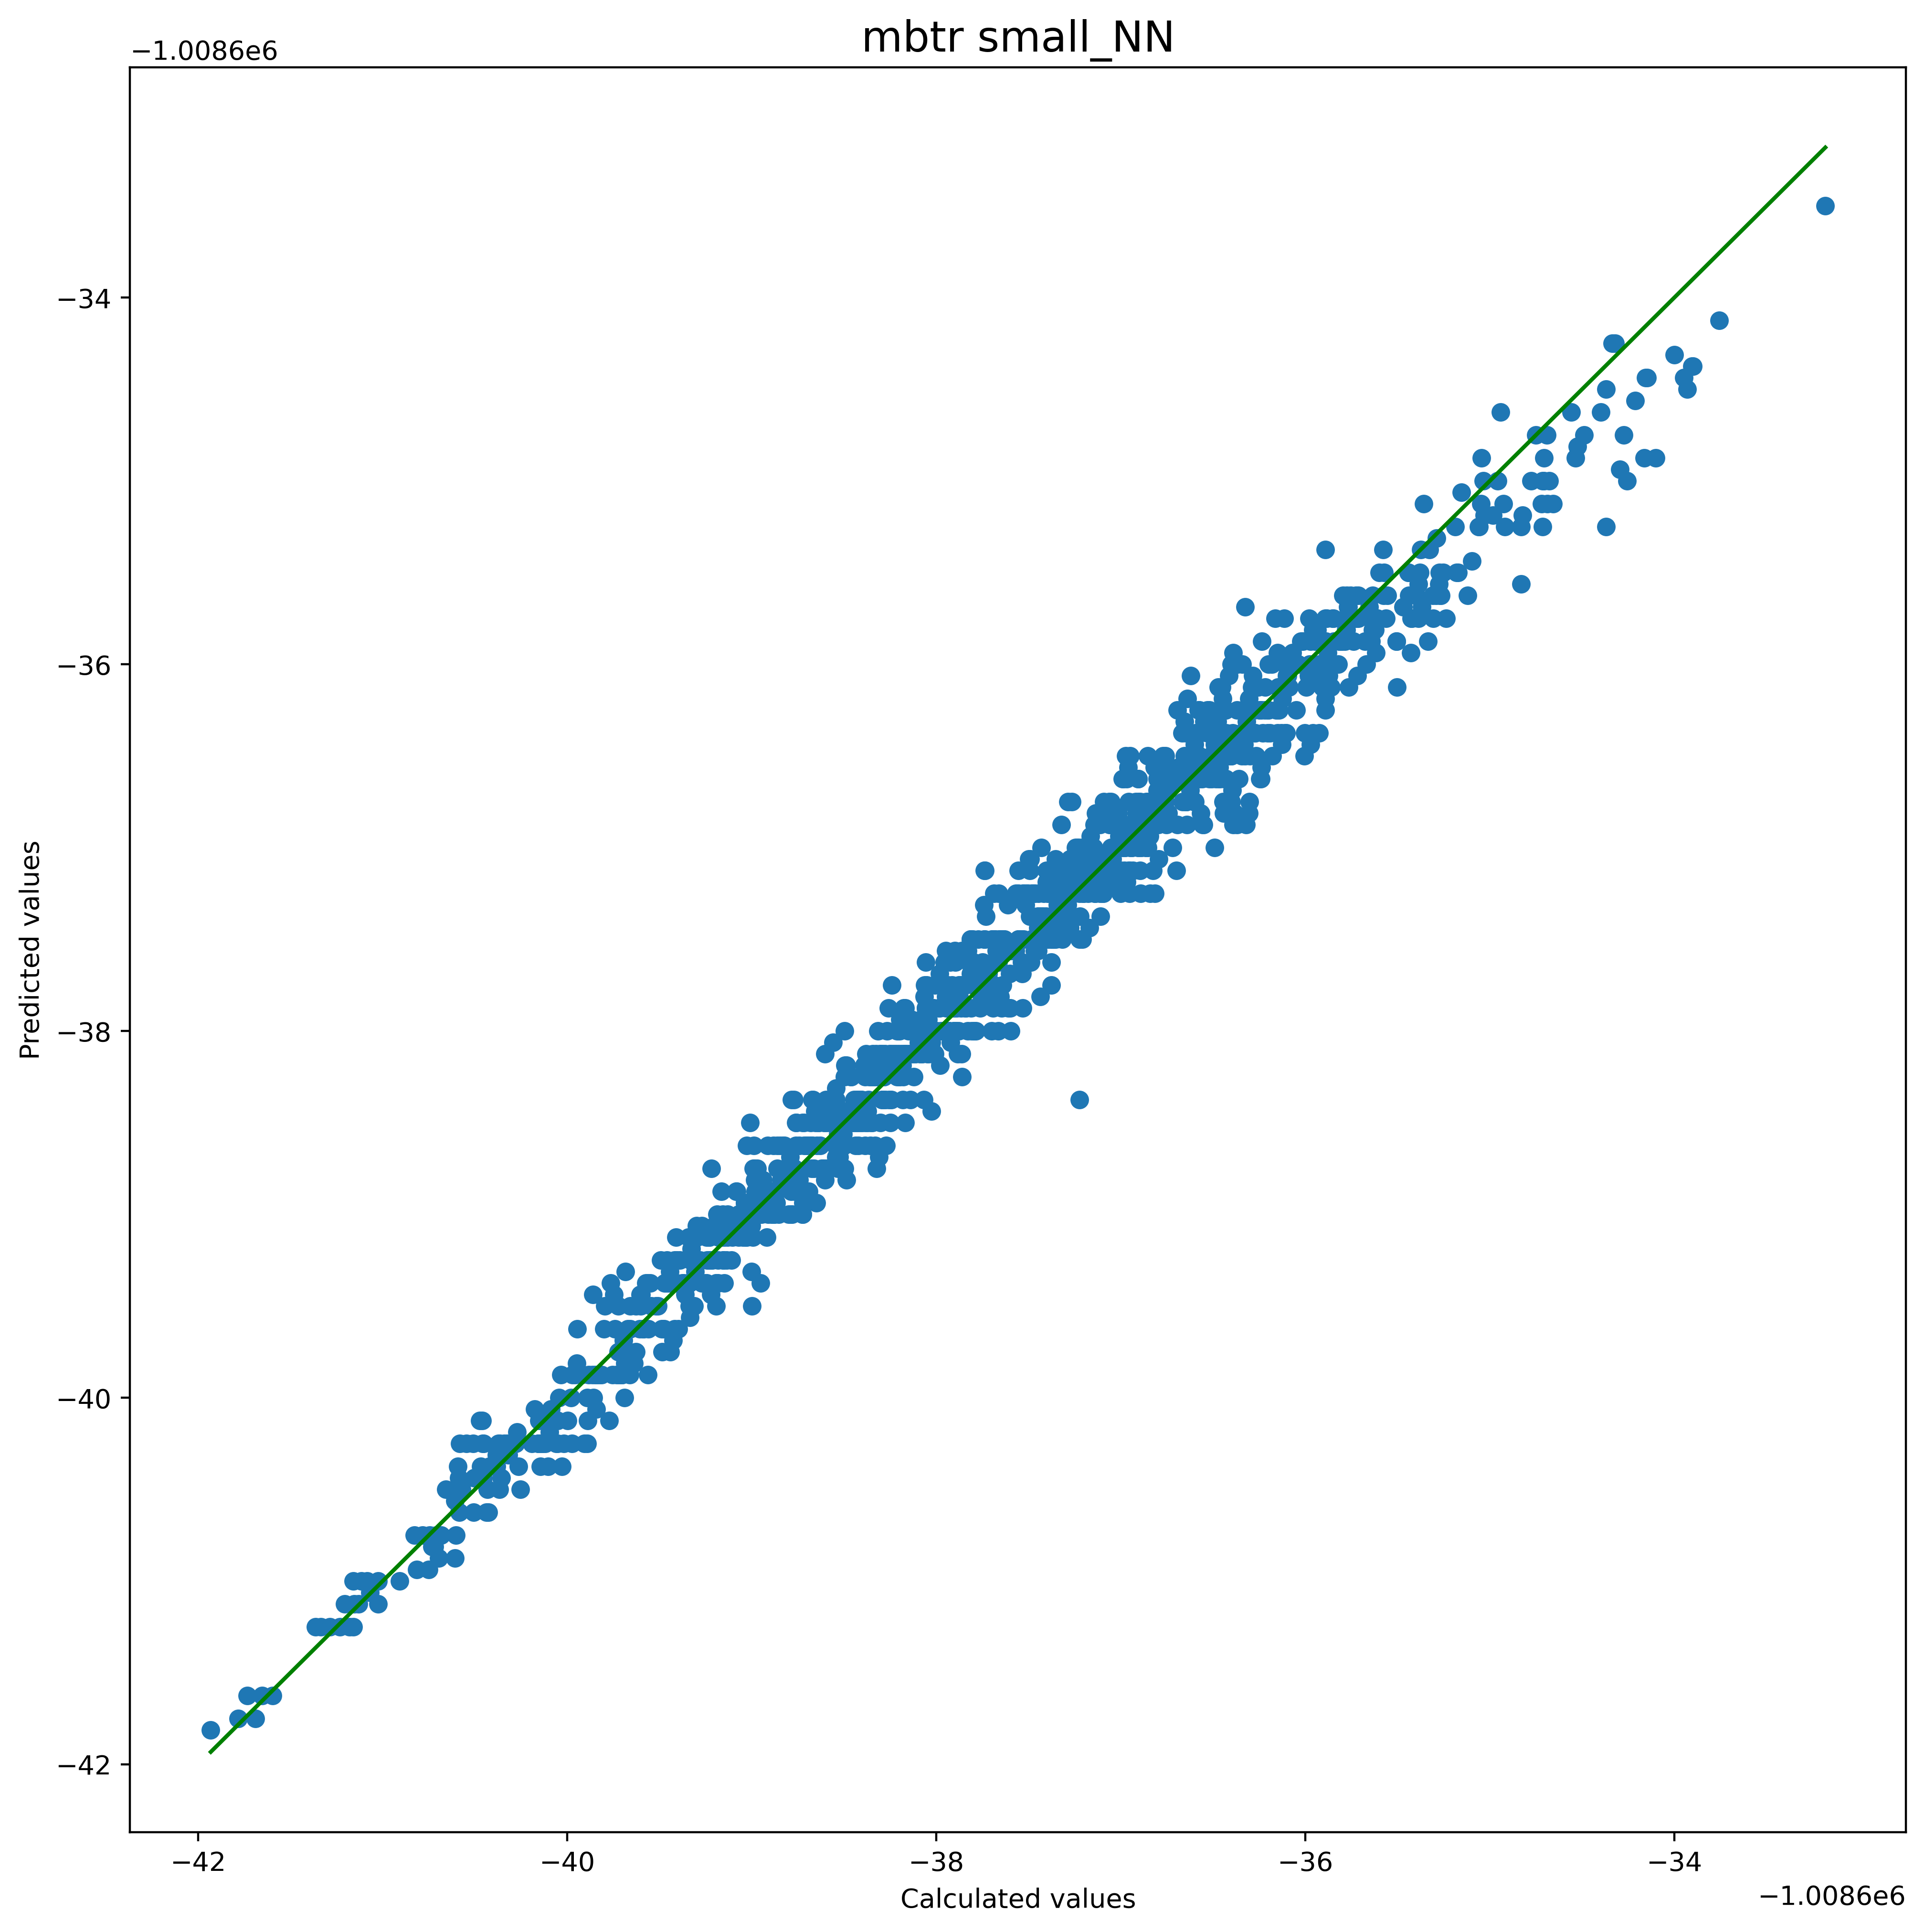

,r^2 value,mean absolute error,maximum error
0,0.981062,161.515023,1151.436588


In [117]:
errorgraph(y_test,ypred, descriptor_name, 'small_NN')

In [118]:
# when the same model is used for MBTR, the train and validation set seems to converge and have
# have the same value, which could possibly mean that the data is underfitted. 
#this is to be expected as the MBTR descriptor is far more complex and would benefit from having more neurons 
#in the layers and increasing the complexity of the model

# EXTRA

In [13]:
#Define generic functions to run ensembles
def train_model(model, index=99, epochs=10000, verbose=0, weights_dir='ensemble_weights/'):
    if not os.path.isdir(weights_dir):
        os.mkdir(weights_dir)
#making a directory to recorded the different models and the different weights    
    
    start=time.time()
    ad = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)    
    #apart from the learning rate, everything is set as default
    
    #checkpoint = ModelCheckpoint(weights_dir + '/best_val_acc_%s.h5' % str(index),verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    stopping =  EarlyStopping(monitor='val_mean_squared_error', patience=750, verbose=0, mode='auto', restore_best_weights=True)
    #monitor: checking the quantity that we are looking at, patience: number of epochs with no imporvement after which training will be stopped
    #mode: the training direction and when it stops is determine by the 'monitor', 
    #restore_best_weights: restoring model weights from the epoch with the best value of the 'monitor'.
    
    model.compile(loss='mean_squared_error', optimizer=ad, metrics=['mean_squared_error'])
    #looking at the mean_squared_error
    
    history = model.fit(Xtrain, ytrain, epochs=epochs, batch_size=32, verbose=verbose, validation_data=(Xval, yval), callbacks=[stopping])
    #included the earlystopping in the model, and batchsize is set to 32,
    #the data of the whole model is recorded here as history
    
    model.save(weights_dir + 'trainedmodel_'+feature+descriptor+str(index)+'.h5')
    #saving the data of the model that has finished running, into a new folder in the directory 
    
    end=time.time()
    print(f"Runtime of the program is {(end - start)/60} min")
    print(len(history.history['mean_squared_error']))
    return history 

#this is the function that predicts the energy, you can either use just 1 model 
#or use multiple models to get predictions 
def ensemble_inference(model, data, num_models=1,fileroot='ensemble_weights/trainedmodel_'):
    #the data, refers to the Xtest
    predictions = np.zeros(shape=(num_models, len(data),1))
    if num_models==1:
        model.load_weights(fileroot+feature+descriptor+str(99)+'.h5')
        #taking the model that was saved
        predictions[0,:,:] = model.predict(data)
    else:
        for i in range(num_models):
            model.load_weights(fileroot+feature+descriptor+str(i)+'.h5')
            #taking the model that was saved
            predictions[i,:,:] = model.predict(data)
    means = np.mean(predictions, axis=0)
    #finding the average values of each of them from the predictions of different models
    std = np.std(predictions, axis=0)
    #see how the prediction varies
    return means, std, predictions


def score_model(realval,preds,print_results=False,graph=False,print_ingraph=False,savegraph=False):
    mae = mean_absolute_error(realval,preds)*1000
    maxerr= max(abs(preds.reshape(len(preds),)-realval))*1000
    r2=r2_score(realval,preds)
    
    if print_results==True:
        print('Mean absolute error {} meV'.format(mae))
        print('Maximum error {} meV'.format(maxerr))
        print('R2 = {}'.format(r2))
    if graph==True:
        if savegraph==True:
            plt.figure(dpi=600)
        else:
            plt.figure()
        plt.plot(realval.reshape(len(preds),),preds,'o')
        vmin=min(min(realval),min(preds));vmax=max(max(realval),max(preds))
        eje=np.linspace(vmin,vmax,10)
        plt.plot(eje,eje)
        plt.ylabel("Predicted values")
        plt.xlabel("Calculated values")
        plt.title("Bandgaps (eV)")
        ax=plt.gca()
        ax.set_xlim([vmin-0.01,vmax+0.01]);ax.set_ylim([vmin-0.01,vmax+0.01])
        ax.set_aspect('equal', adjustable='box')
        if print_ingraph==True:
            xtags=vmin+0.07*(vmax-vmin)
            yperc=np.array([0.9,0.85,0.8,0.75,0.7,0.65,0.6])
            ytags=vmin+yperc*(vmax-vmin)
            plt.text(xtags,ytags[0], "MAE = "+'%.2f' % (mae) +" meV")
            plt.text(xtags,ytags[1], r'$\epsilon$$_{max}$ = '+'%.2f' % (maxerr) +" meV")
            plt.text(xtags,ytags[2], r'R$^2$ = '+'%.3f' % r2)
        if savegraph==True:
            plt.savefig('MLP_'+descriptor+feature+".png")
        plt.show()
        plt.close()
